# Spotify Sequential Skip Prediction

##1 Introduction

In many music streaming services such as Spotify, personalized music recommendation systems play a prominent role. These recommendation systems allow the user to listen to suggested music based on a particular song, the user’s mood, time, or location. The vast amount of available music and diverse interests exhibited by various users, as well as by the same user during different situations pose considerable challenges to such systems. 

The specific goal of the project was to predict whether a listener will skip a certain song using features such as track audio features and user behavior features. By understanding the factors influencing sequencial skip behaviors and predicting them with machine learning models, the system can dynamically adjust and optimize playlists or recommendations to suit individual users' preferences, ultimately improving their overall experience on the platform.


### 1.1 Data Source
We used the dataset from Spotify Sequential Skip Prediction Challenge (https://www.aicrowd.com/challenges/spotify-sequential-skip-prediction-challenge/dataset_files). 

Due to the large size of the dataset and lack of good hardware, we choose to use a sample dataset containing about 167,881 sessions and 51 features. The length of each session varies from 10 to 20 tracks. Metadata such as duration, release year, and US popularity estimate are provided for every track. Also, audio features such as acousticness, tempo, and loudness are provided. For each track the user was presented within the session, interactions such as seek forward/backwards, and short/long pause before play are available. Finally, session information such as the time of the day, date, the premium user or not, and context type of playlist is present. 

In the dataset, skipping behavior is classified into four types: 
(1) skip_1: Boolean indicating if the track was only played very briefly 
(2) skip_2: Boolean indicating if the track was only played briefly 
(3) skip_3: Boolean indicating if most of the track was played 
(4) not_skipped: Boolean indicating that the track was played in its entirety. 
The objective of the challenge is limited to predicting just the skip_2 behavior.


## 2 Exploratory Data Analysis


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
sns.set()
from functools import partial
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, classification_report, log_loss
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
!pip install category_encoders
import category_encoders as ce
!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
import seaborn as sns 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
!pip install tensorflow_decision_forests
!pip install wurlitzer
import tensorflow_decision_forests as tfdf
import os
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 2.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 24.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 2.1 Load dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
track_features = pd.read_csv('/content/drive/MyDrive/CIS545/final project/data/tf_mini.csv')
training_set = pd.read_csv('/content/drive/MyDrive/CIS545/final project/data/log_mini.csv')

In [4]:
print('track features size： ',track_features.shape)
print('training set size: ',training_set.shape)

track features size：  (50704, 30)
training set size:  (167880, 21)


###2.2 Track features exploration
Full feature explaination see https://developer.spotify.com/documentation/web-api/reference/get-audio-features


#### 2.2.1 Dataset overview

In [5]:
track_features.head()

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_a540e552-16d4-42f8-a185-232bd650ea7d,109.706673,1950,99.975414,0.458040,0.519497,0.504949,0.399767,7.511880,0.817709,...,4,0.935512,-0.033284,-0.411896,-0.028580,0.349438,0.832467,-0.213871,-0.299464,-0.675907
1,t_67965da0-132b-4b1e-8a69-0ef99b32287c,187.693329,1950,99.969430,0.916272,0.419223,0.545530,0.491235,9.098376,0.154258,...,3,0.359675,0.145703,-0.850372,0.123860,0.746904,0.371803,-0.420558,-0.213120,-0.525795
2,t_0614ecd3-a7d5-40a1-816e-156d5872a467,160.839996,1951,99.602549,0.812884,0.425890,0.508280,0.491625,8.368670,0.358813,...,4,0.726769,0.021720,-0.743634,0.333247,0.568447,0.411094,-0.187749,-0.387599,-0.433496
3,t_070a63a0-744a-434e-9913-a97b02926a29,175.399994,1951,99.665018,0.396854,0.400934,0.359990,0.552227,5.967346,0.514585,...,4,0.859075,0.039143,-0.267555,-0.051825,0.106173,0.614825,-0.111419,-0.265953,-0.542753
4,t_d6990e17-9c31-4b01-8559-47d9ce476df1,369.600006,1951,99.991764,0.728831,0.371328,0.335115,0.483044,5.802681,0.721442,...,4,0.562343,0.131931,-0.292523,-0.174819,-0.034422,0.717229,-0.016239,-0.392694,-0.455496


In [6]:
track_features.describe()

,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
count,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,...,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000
mean,222.267980,2010.324748,99.455131,0.250336,0.492075,0.514526,0.611742,8.215950,0.641440,0.996548,...,3.913163,0.487804,-0.332295,0.202193,0.153935,-0.040526,-0.027247,0.049475,-0.197758,0.005153
std,72.224839,11.471866,1.139222,0.276047,0.158102,0.182595,0.166146,2.410626,0.207957,0.045611,...,0.410036,0.246376,0.416320,0.254024,0.212660,0.333129,0.377457,0.144205,0.349840,0.324259
min,30.013330,1950.000000,90.018900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.122792,-1.084360,-0.752231,-0.809136,-1.029858,-0.942461,-0.736395,-0.975647
25%,183.933334,2009.000000,99.509670,0.025291,0.374378,0.372463,0.502499,6.356671,0.507839,0.975910,...,4.000000,0.292559,-0.745148,0.086460,0.051604,-0.294574,-0.318751,-0.038337,-0.444849,-0.176821
50%,214.866669,2015.000000,99.865444,0.135821,0.493764,0.522266,0.625145,8.015075,0.661368,1.003790,...,4.000000,0.478244,-0.334799,0.265535,0.207705,-0.001755,-0.176974,0.062719,-0.298599,0.090423
75%,250.426666,2017.000000,99.961131,0.406142,0.604994,0.655912,0.736241,9.792092,0.803185,1.026137,...,4.000000,0.677947,0.045921,0.359553,0.296132,0.146828,0.280852,0.160366,-0.075158,0.194285
max,1787.760986,2018.000000,99.999997,0.995796,0.990419,0.972590,0.984952,32.342781,0.999877,1.103213,...,5.000000,0.999990,0.932165,0.812837,0.605288,1.074504,0.895769,0.380279,0.966760,1.152213


In [7]:
track_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50704 entries, 0 to 50703
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   track_id                50704 non-null  object 
 1   duration                50704 non-null  float64
 2   release_year            50704 non-null  int64  
 3   us_popularity_estimate  50704 non-null  float64
 4   acousticness            50704 non-null  float64
 5   beat_strength           50704 non-null  float64
 6   bounciness              50704 non-null  float64
 7   danceability            50704 non-null  float64
 8   dyn_range_mean          50704 non-null  float64
 9   energy                  50704 non-null  float64
 10  flatness                50704 non-null  float64
 11  instrumentalness        50704 non-null  float64
 12  key                     50704 non-null  int64  
 13  liveness                50704 non-null  float64
 14  loudness                50704 non-null

From information table, we can see there is no null row.

#### 2.2.2 Feature exploration 

##### Categorical features
Select all the categorical data and change data type to object for future encoding.

In [8]:
track_categorical_col = ['release_year','key','mode','time_signature']
for colname in track_categorical_col:
    track_features[colname] = track_features[colname].astype(object,copy=False)

Examine `release_year`

From the graph we can find that songs released in the last two decades make up the majority of the sample.

<Figure size 600x2000 with 0 Axes>

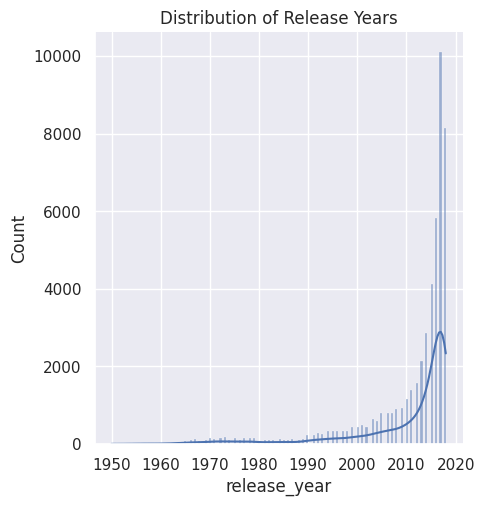

In [9]:
plt.figure(figsize=(6,20))
sns.displot(track_features, x="release_year", kde=True)
plt.title("Distribution of Release Years");

Examine `key`

We then examine the distribution of the key the tracks are in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

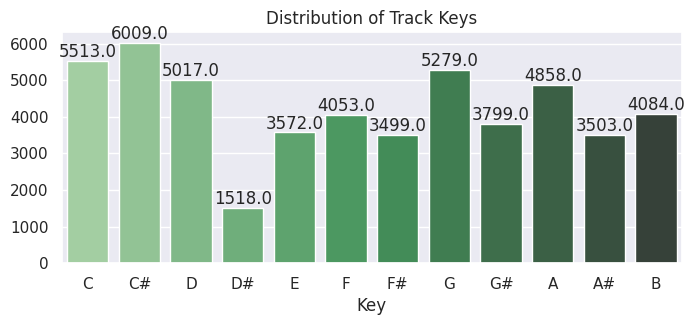

In [10]:
# Key-mappings are from the dataset docs https://en.wikipedia.org/wiki/Pitch_class
plt.figure(figsize=(8,3))
keys = track_features.key.value_counts().sort_index()
ax =sns.barplot(
    x=[ 
        "C",
        "C#",
        "D",
        "D#",
        "E",
        "F",
        "F#",
        "G",
        "G#",
        "A",
        "A#",
        "B"
    ],
    y=keys.values
    , palette="Greens_d"
)
plt.title("Distribution of Track Keys")
ax.bar_label(ax.containers[0], labels=[str(v) if v else '' for v in ax.containers[0].datavalues])
plt.xlabel("Key");

Examine `mode`

Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived.

In [11]:
import plotly.express as px
fig = px.pie(track_features['mode'], names='mode', color_discrete_sequence=px.colors.sequential.Mint)
fig.show()

Examine `time_signatures`

An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".

In [12]:
tf = track_features.time_signature.value_counts().sort_index()
print('Counts of time signature:')
print(tf)

Counts of time signature:
0       28
1      413
3     3897
4    45521
5      845
Name: time_signature, dtype: int64


From the distribution we can see that the majority of tracks are of 4/4 time signature, which reflects the facts that 4/4 is by far the most popular time signature in the world. With four steady beats in each measure, it provides for a very stable rhythm. 

In [13]:
fig = px.pie(track_features['time_signature'], names='time_signature',color_discrete_sequence=px.colors.sequential.Sunset)
fig.show()

##### Numeric features

We first check the descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution.

In [14]:
track_features.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,50704.0,222.267980,72.224839,30.013330,1.839333e+02,214.866669,250.426666,1787.760986
us_popularity_estimate,50704.0,99.455131,1.139222,90.018900,9.950967e+01,99.865444,99.961131,99.999997
acousticness,50704.0,0.250336,0.276047,0.000000,2.529069e-02,0.135821,0.406142,0.995796
beat_strength,50704.0,0.492075,0.158102,0.000000,3.743785e-01,0.493764,0.604994,0.990419
bounciness,50704.0,0.514526,0.182595,0.000000,3.724626e-01,0.522266,0.655912,0.972590
danceability,50704.0,0.611742,0.166146,0.000000,5.024992e-01,0.625145,0.736241,0.984952
dyn_range_mean,50704.0,8.215950,2.410626,0.000000,6.356671e+00,8.015075,9.792092,32.342781
energy,50704.0,0.641440,0.207957,0.000000,5.078394e-01,0.661368,0.803185,0.999877
flatness,50704.0,0.996548,0.045611,0.000000,9.759097e-01,1.003790,1.026137,1.103213
instrumentalness,50704.0,0.070587,0.214226,0.000000,1.084167e-08,0.000002,0.000765,0.999399


We first plot the distribution of duration and popularity estimate. 

We can see that popularity feature distribution plots indicates a long tail distribution, larger share of population rests within its tail while the duration feature is close to be under a normal distribution. 

This distribution reflects the real situation of music industry is a long tail market itself such that how massive the pool of artists is, yet count the subset of popular artists and genres on a single hand. Thus, the tracks being listened to are mostly popular songs with high explosure to the users, resulting a very unbalanced distribution of popularity.

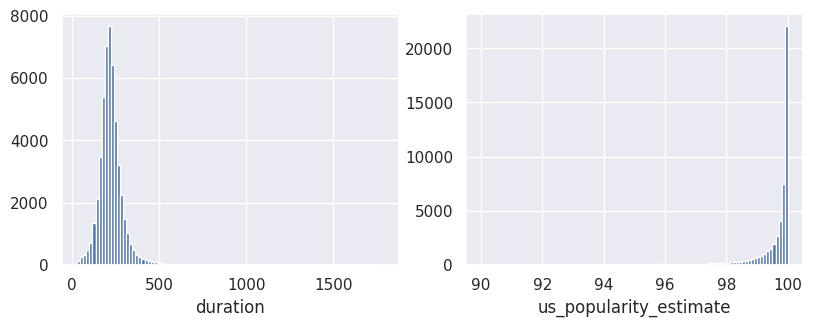

In [15]:
col_1 = ['duration','us_popularity_estimate']

plt.figure(figsize=(20,15))
n = 1
for i in range(0,len(col_1)):
    plt.subplot(4,4,n)
    track_features[col_1[i]].hist(bins=100)
    plt.xlabel(col_1[i])
    n +=1

We then plot the acousticness-related features. The distribution of instrumentainess are densely concentrated around 0 as only a small portion of users only listen to instrumental music.

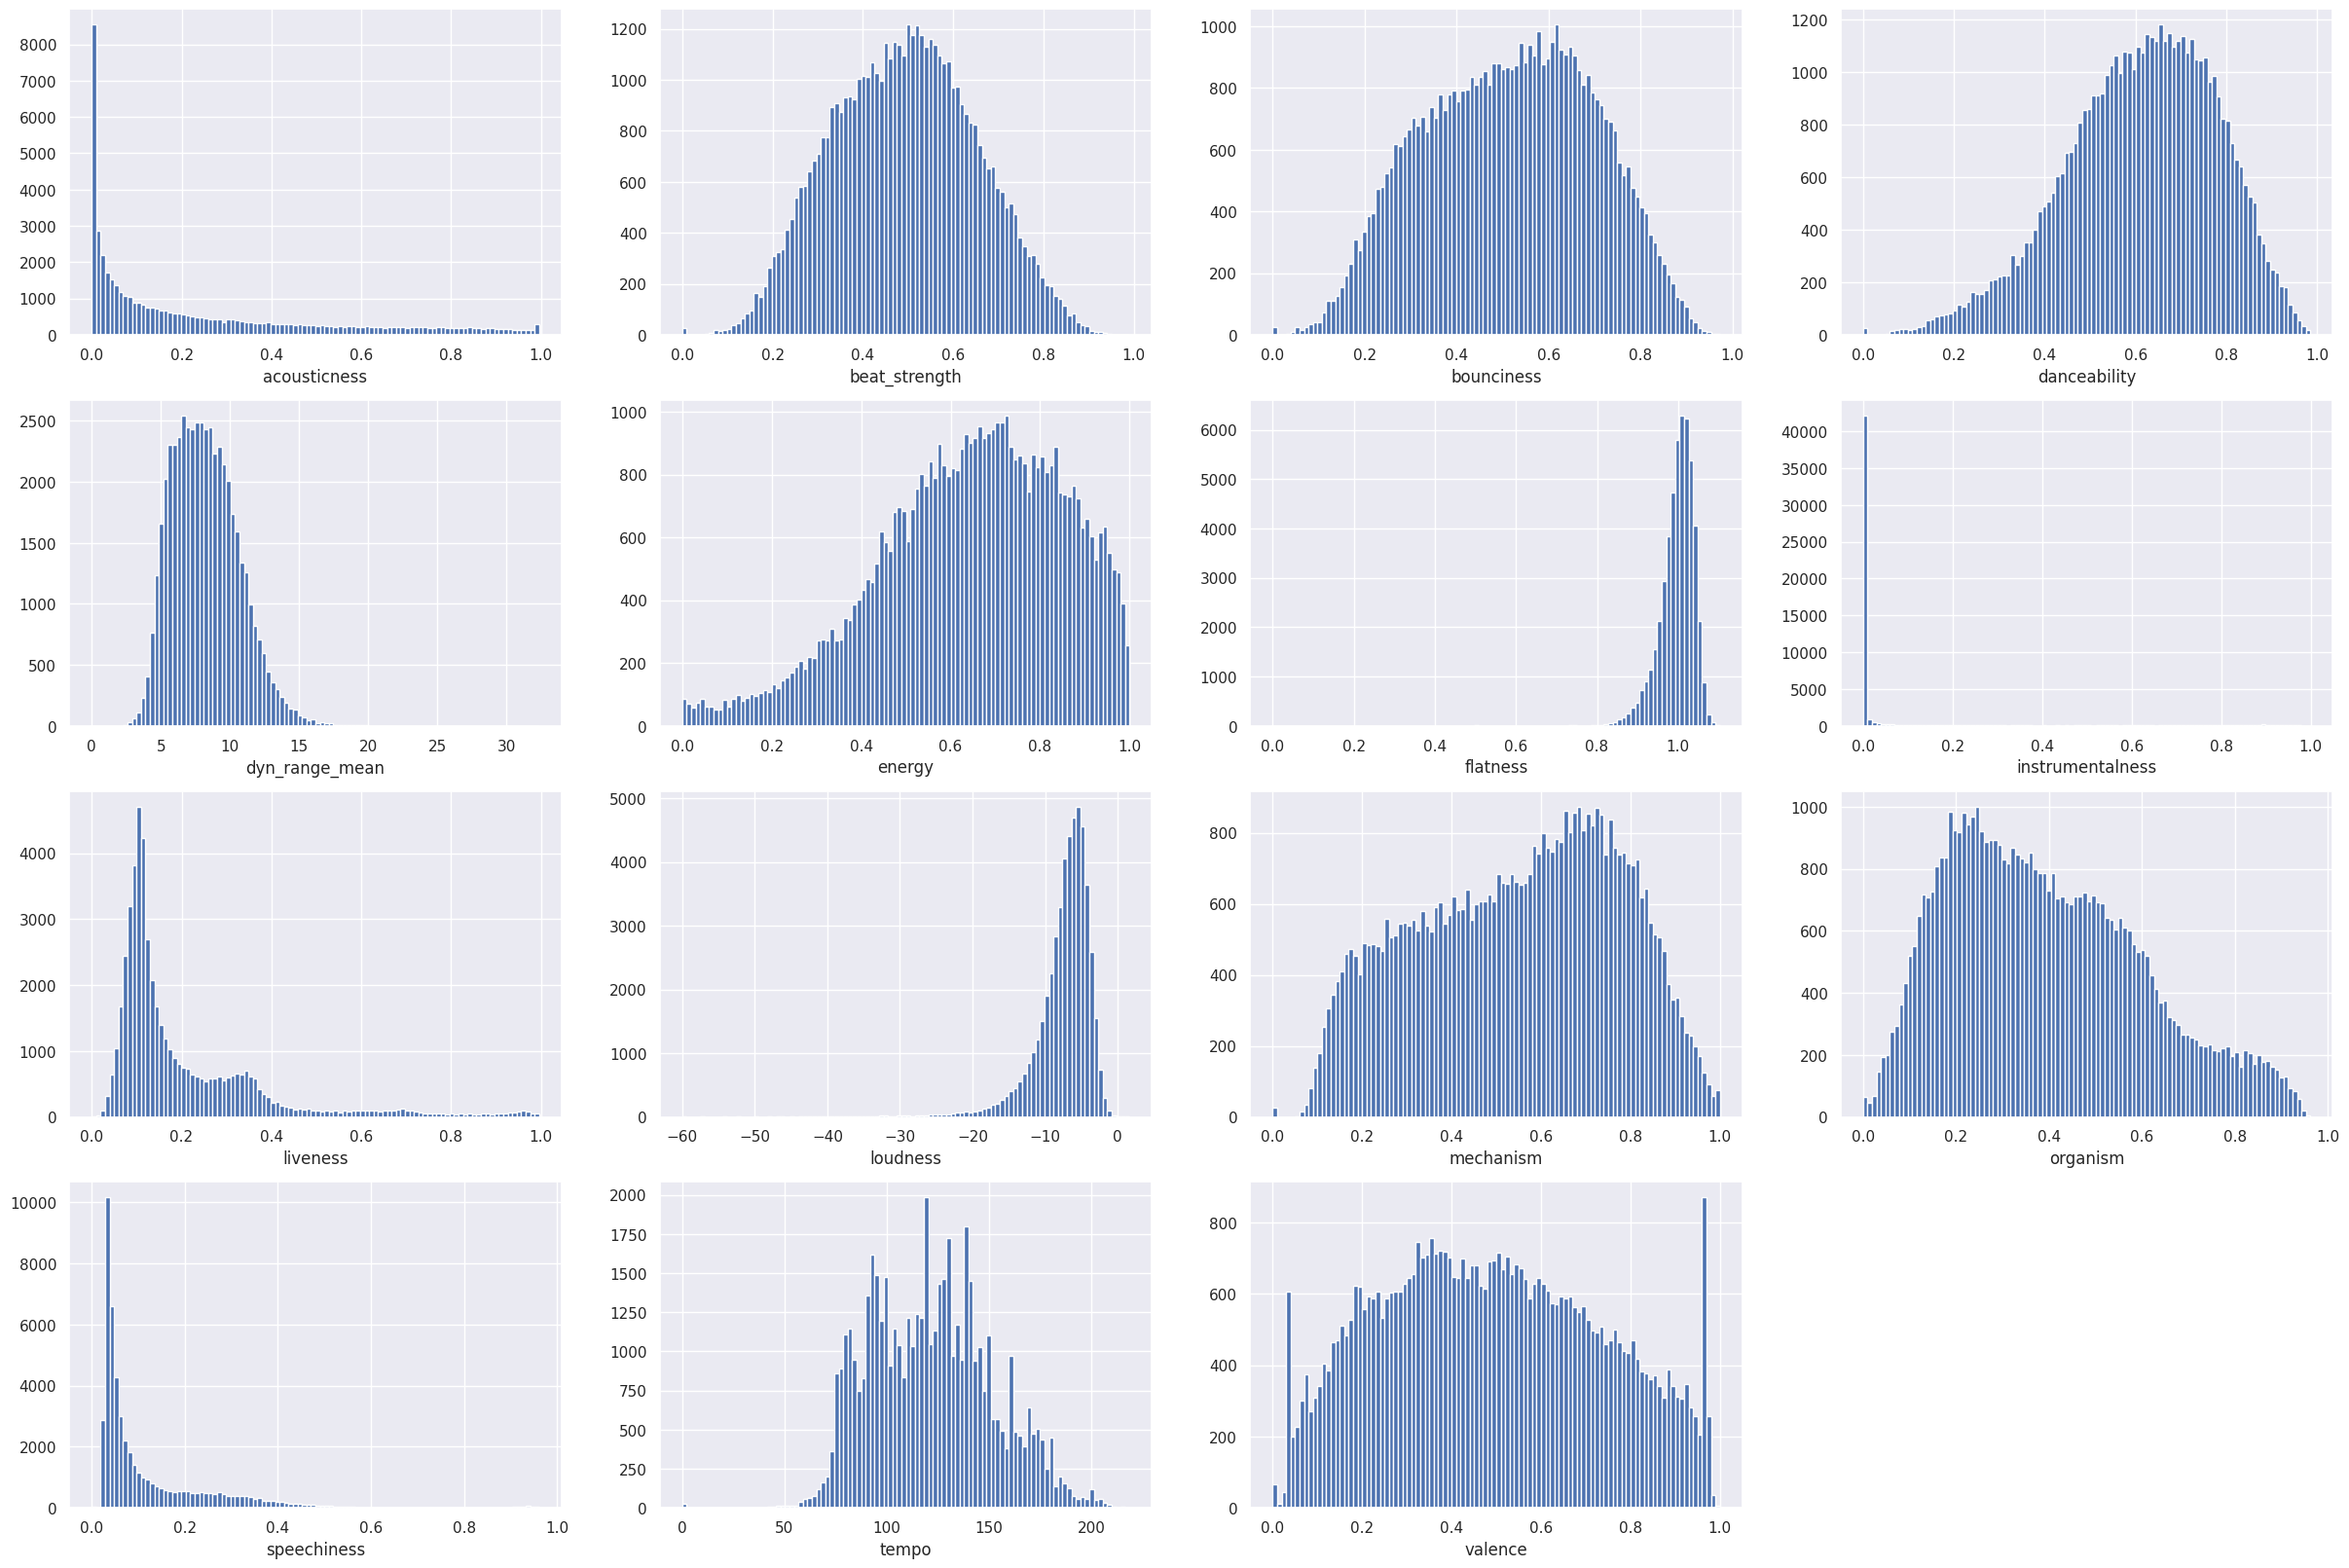

In [16]:
acousticness=['acousticness','beat_strength','bounciness',
       'danceability','dyn_range_mean','energy',
       'flatness','instrumentalness','liveness',
       'loudness','mechanism','organism',
       'speechiness','tempo','valence']

plt.figure(figsize=(30,20))
n = 1

for i in range(0,len(acousticness)):
    plt.subplot(4,4,n)
    track_features[acousticness[i]].hist(bins=100)
    plt.xlabel(acousticness[i])
    n +=1

Lastly we plot the acoustic vector features. We can see that the distribution are very different from each other.

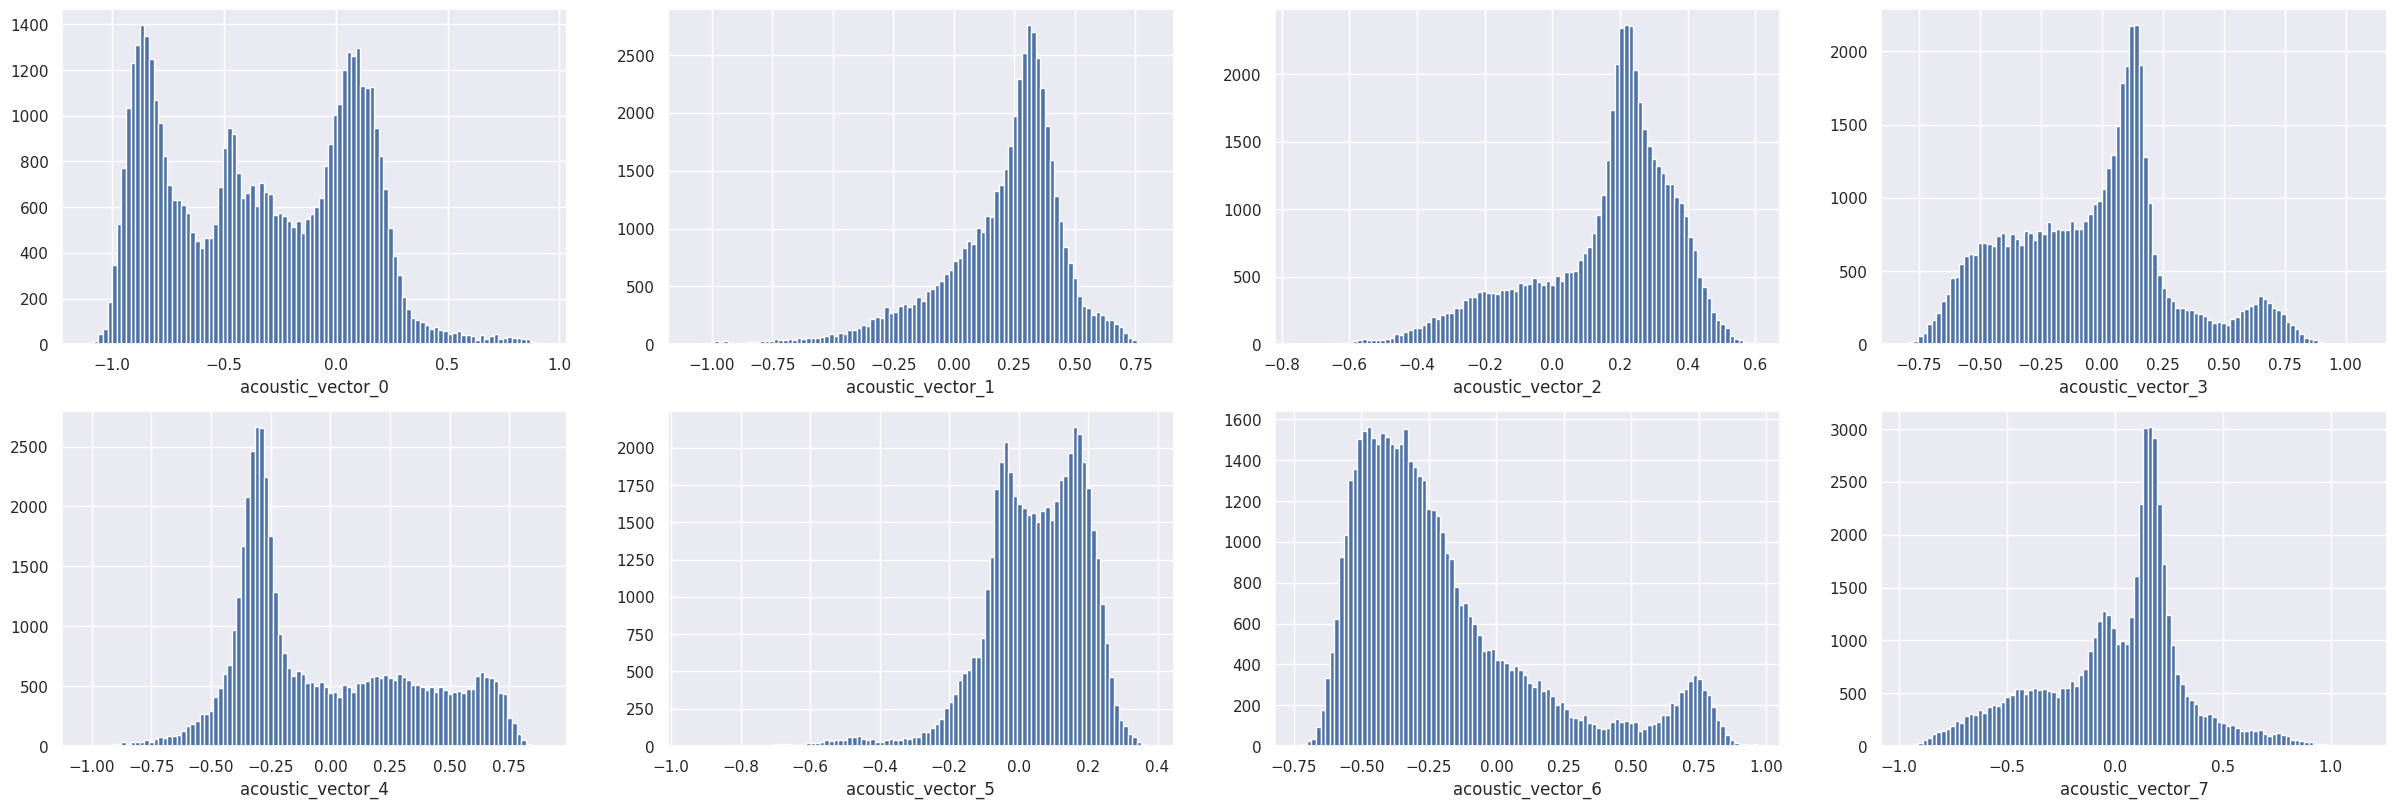

In [17]:
acoustic_vector = ['acoustic_vector_0','acoustic_vector_1',
       'acoustic_vector_2','acoustic_vector_3','acoustic_vector_4',
       'acoustic_vector_5','acoustic_vector_6','acoustic_vector_7']

plt.figure(figsize=(30,20))
n = 1
for i in range(0,len(acoustic_vector)):
    plt.subplot(4,4,n)
    track_features[acoustic_vector[i]].hist(bins=100)
    plt.xlabel(acoustic_vector[i])
    n +=1



### 2.3 Listening session dataset exploration

#### 2.3.1 Dataset overview

In [18]:
training_set.nunique()

session_id                         10000
session_position                      20
session_length                        11
track_id_clean                     50704
skip_1                                 2
skip_2                                 2
skip_3                                 2
not_skipped                            2
context_switch                         2
no_pause_before_play                   2
short_pause_before_play                2
long_pause_before_play                 2
hist_user_behavior_n_seekfwd          25
hist_user_behavior_n_seekback         30
hist_user_behavior_is_shuffle          2
hour_of_day                           24
date                                  18
premium                                2
context_type                           6
hist_user_behavior_reason_start        9
hist_user_behavior_reason_end          7
dtype: int64

In [19]:
# convert date into weekdays
training_set['date'] = pd.to_datetime(training_set['date'])
training_set['day_of_week']=training_set['date'].dt.dayofweek
training_set = training_set.drop(columns='date')
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167880 entries, 0 to 167879
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   session_id                       167880 non-null  object
 1   session_position                 167880 non-null  int64 
 2   session_length                   167880 non-null  int64 
 3   track_id_clean                   167880 non-null  object
 4   skip_1                           167880 non-null  bool  
 5   skip_2                           167880 non-null  bool  
 6   skip_3                           167880 non-null  bool  
 7   not_skipped                      167880 non-null  bool  
 8   context_switch                   167880 non-null  int64 
 9   no_pause_before_play             167880 non-null  int64 
 10  short_pause_before_play          167880 non-null  int64 
 11  long_pause_before_play           167880 non-null  int64 
 12  hist_user_behavi

From info we can see there is no null data. From the describe table we can see that there is no extreme and invalid data.

#### 2.3.2 Feature exploration

##### Categorical features

We first select all the categorical data and change data type to object for future encoding

In [20]:
train_categorical_col = ['session_position','skip_1','skip_2','skip_3',
       'not_skipped','context_switch','no_pause_before_play',
       'short_pause_before_play','long_pause_before_play','hist_user_behavior_is_shuffle',
       'premium','context_type','hist_user_behavior_reason_start',
       'hist_user_behavior_reason_end','hour_of_day','day_of_week']

for colname in train_categorical_col:
    training_set[colname] = training_set[colname].astype(object,copy=False)

There are 4 features directly related to skip behaviors, and each consists of two categories. 

*   **skip_1** indicates if the track was onlyplayed very briefly
*   **skip_2** indicates if the track was only played briefly. 
*   **skip_3** indicates if most of the track was played
*   **not_skipped** indicates that the track was played

and 6 features that have potential implications for skipping behavior:

*   **context_switch** indicates if the user changed context between the previous row and the current row. This could for example occur if the user switched from one playlist to another.

*   **no_pause_before_play** indicates if there was no pause between playback of the previous track and this track

*   **short_pause_before_play** indicates if there was a short pause
between playback of the previous track and
this track

*  **long_pause_before_play** indicates if there was a long pause
between playback of the previous track and
this track

*   **hist_user_behavior_is_shuffle** indicates if the user encountered
this track while shuffle mode was activated

*   **premium** indicates if the user was on premium or not.


We first count the 1 and 0 values and compute the percentage table. Then we plot the distribution percentage of each features to explore the patterns.

In [21]:
# count the 1 and 0 values
skip_table = training_set[['skip_1','skip_2','skip_3','not_skipped','context_switch','no_pause_before_play',
       'short_pause_before_play','long_pause_before_play','hist_user_behavior_is_shuffle',
       'premium']].astype(int).apply(pd.Series.value_counts)

skip_table = skip_table.rename(index={0: 'false',1:'true'})
skip_table.T

,false,true
skip_1,97118,70762
skip_2,81056,86824
skip_3,59030,108850
not_skipped,111996,55884
context_switch,161013,6867
no_pause_before_play,39015,128865
short_pause_before_play,143263,24617
long_pause_before_play,138865,29015
hist_user_behavior_is_shuffle,116050,51830
premium,31827,136053


In [22]:
# compute the percentage table
col = skip_table.columns
for i in range(0,len(skip_table.columns)):
  skip_table[col[i]] = (skip_table[col[i]]/ skip_table[col[i]].sum())*100
skip_table=skip_table.T
skip_table

,false,true
skip_1,57.849655,42.150345
skip_2,48.282106,51.717894
skip_3,35.162020,64.837980
not_skipped,66.711937,33.288063
context_switch,95.909578,4.090422
no_pause_before_play,23.239814,76.760186
short_pause_before_play,85.336550,14.663450
long_pause_before_play,82.716822,17.283178
hist_user_behavior_is_shuffle,69.126757,30.873243
premium,18.958184,81.041816


From the plat below we can see that 

*  In terms of direct skipping behavior features: 
  *    More than 66% of the users did not skip the tracks and the distribution of the skip_2 feature we are using to predict skip behaviors is quite balanced.

*   In terms of indirectly related skipping behavior features: 
  *    Majorty of the users did not experience context switch in listen sessions and have listened to tracks sequentially without pause. 
  *    Only 18% of the users have subscribed to premium membership. 
  *    About 30% of the listen sessions users like to shuffle songs.

 

[Text(0, 0, '57%'),
 Text(0, 0, '48%'),
 Text(0, 0, '35%'),
 Text(0, 0, '66%'),
 Text(0, 0, '95%'),
 Text(0, 0, '23%'),
 Text(0, 0, '85%'),
 Text(0, 0, '82%'),
 Text(0, 0, '69%'),
 Text(0, 0, '18%')]

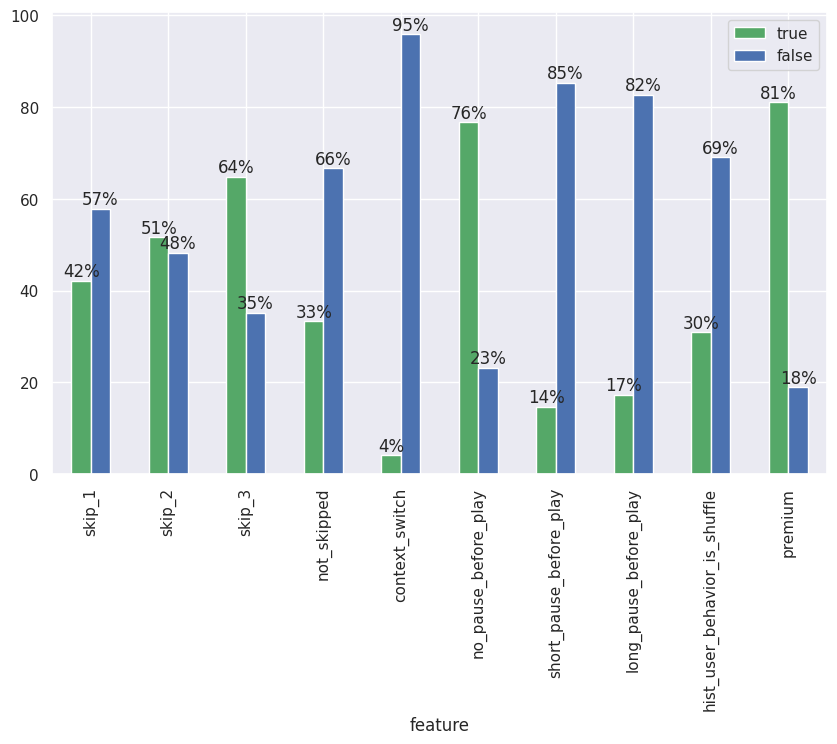

In [23]:
skip_table['feature']=skip_table.index
ax = skip_table.plot(x="feature", y=['true', 'false'], kind="bar", figsize=(10, 6),color = ['g','b'])
ax.bar_label(ax.containers[0], labels=[str(int(v))+'%' if v else '' for v in ax.containers[0].datavalues])
ax.bar_label(ax.containers[1], labels=[str(int(v))+'%' if v else '' for v in ax.containers[1].datavalues])

Lets then explore the 3 categorical features that have more than 2 categories and also might have potential influence on skipping behaviors.


*   **context_type**: E.g. editorial playlist - what type of context the playback occurred within

*   **hist_user_behavior_reason_start**: E.g. fwdbtn - the user action which led to the current track being played

*   **hist_user_behavior_reason_end**: E.g. trackdone - the user action which led to the current track playback ending

From the plot we can see that users prefered listen to the tracks in their own collections and most track are listened to sequentially in their playlist

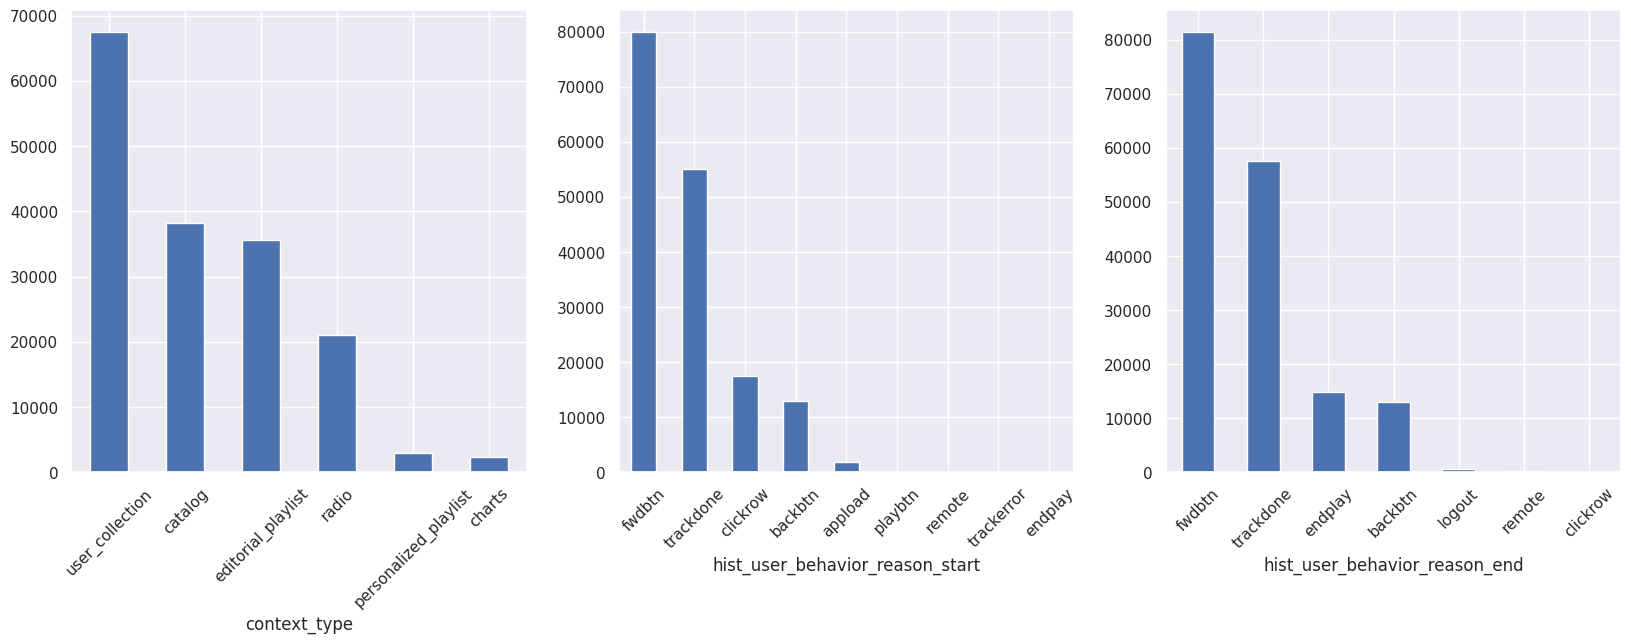

In [24]:
col_type = ['context_type','hist_user_behavior_reason_start','hist_user_behavior_reason_end']

plt.figure(figsize=(20,6))
n = 1

for colname in col_type:
    plt.subplot(1,3,n)
    training_set[colname].value_counts().plot(kind='bar')
    plt.xlabel(colname)
    plt.xticks(rotation = 45)
    n +=1

We then explore the pattern of session where the track locates in:


*   **session_position**: {1-20} - position of row within session
*   **session_length**(numerical): {10-20} - number of rows in session

From plot we can see that the mojority sessions has 20 rows.

[Text(0.5, 1.0, 'Hour of day distribution')]

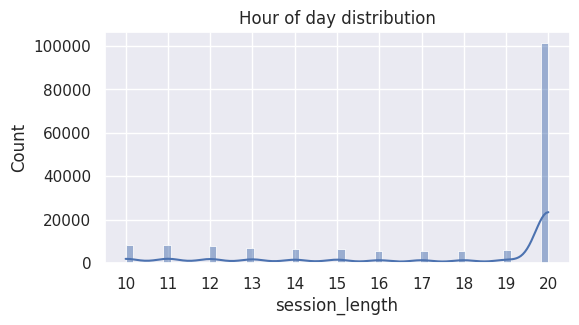

In [25]:
# plot distribution
plt.figure(figsize=(6,3))
ax = sns.histplot(data=training_set, x="session_length", kde=True)
ax.set_xticks(ticks=range(10,21))
ax.set(title='Hour of day distribution')

[Text(0.5, 1.0, 'Hour of day distribution')]

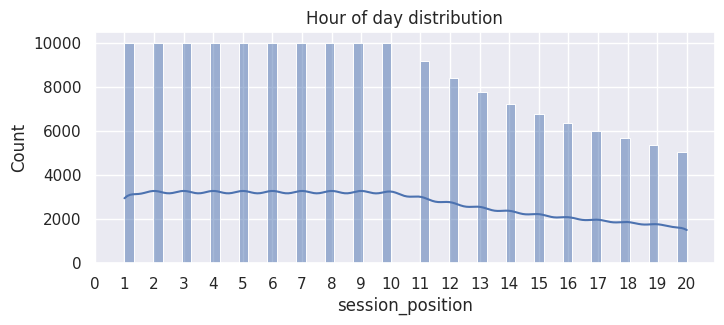

In [26]:
# plot distribution
plt.figure(figsize=(8,3))
ax = sns.histplot(data=training_set, x="session_position", kde=True)
ax.set_xticks(ticks=range(0,21))
ax.set(title='Hour of day distribution')

Lastly, we explore the time-related features: **hour_of_day** and **day_of_week**.

From the distribution plot we can see that:

*   The hour_of_day distribution is in line with the normal biological clock of human.
*   71% of all records are concentrated on Sundays, 27% are concentrated on Saturdays, and weekend listening accounts for almost all of the listening sample.



[Text(0.5, 1.0, 'Hour of day distribution')]

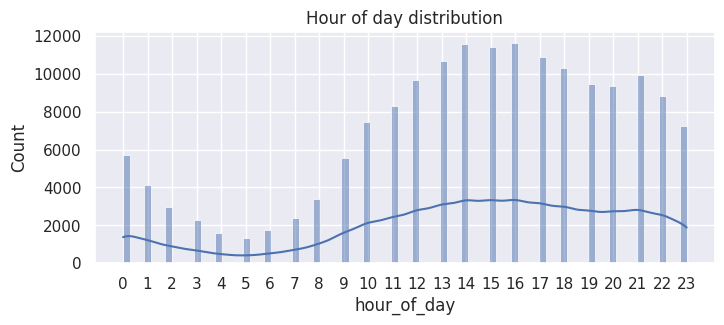

In [27]:
# plot distribution
plt.figure(figsize=(8,3))
ax = sns.histplot(data=training_set, x="hour_of_day", kde=True)
ax.set_xticks(ticks=range(0,24))
ax.set(title='Hour of day distribution')

In [28]:
# compute percentage
(training_set['day_of_week'].value_counts()/training_set['hour_of_day'].count())*100

6    71.264594
5    27.935430
4     0.355611
3     0.179890
2     0.116154
1     0.109602
0     0.038718
Name: day_of_week, dtype: float64

[Text(0.5, 1.0, 'Day of week distribution')]

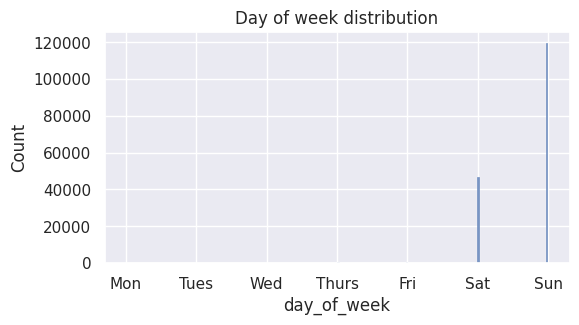

In [29]:
# plot distribution
plt.figure(figsize=(6,3))
ax = sns.histplot(data=training_set, x="day_of_week")
ax.set_xticks(ticks=range(0,7),labels=['Mon','Tues','Wed','Thurs','Fri','Sat','Sun'])
ax.set(title='Day of week distribution')

##### Numeric features

We first check the descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution.

In [30]:
training_set.describe()

,session_length,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback
count,167880.000000,167880.000000,167880.000000
mean,17.651823,0.038909,0.046259
std,3.422025,0.367295,0.606558
min,10.000000,0.000000,0.000000
25%,15.000000,0.000000,0.000000
50%,20.000000,0.000000,0.000000
75%,20.000000,0.000000,0.000000
max,20.000000,60.000000,151.000000


We then explore the distribution of numeric data, which is 

*   **hist_user_behavior_n_seekfwd**: indicates the number of times the user did a seek forward within track
*   **hist_user_behavior_n_seekback**: indicates the number of times the user did a seek back within track

We counts each unique values and compute the percentage distribution. The data distribution of these two features indicates that in approximately 97% of the sessions the user did not have a single action of seek forward or seek back.

In [31]:
# hist_user_behavior_n_seekfwd
df_fwd = training_set['hist_user_behavior_n_seekfwd'].value_counts()
print(df_fwd)
# compute percentage
(training_set['hist_user_behavior_n_seekfwd'].value_counts()/training_set['hist_user_behavior_n_seekfwd'].count())*100

0     163216
1       3786
2        536
3        184
4         65
5         36
6         17
8          8
7          7
9          5
14         3
29         2
15         2
12         2
22         1
11         1
38         1
20         1
24         1
10         1
25         1
60         1
16         1
23         1
19         1
Name: hist_user_behavior_n_seekfwd, dtype: int64


0     97.221825
1      2.255182
2      0.319276
3      0.109602
4      0.038718
5      0.021444
6      0.010126
8      0.004765
7      0.004170
9      0.002978
14     0.001787
29     0.001191
15     0.001191
12     0.001191
22     0.000596
11     0.000596
38     0.000596
20     0.000596
24     0.000596
10     0.000596
25     0.000596
60     0.000596
16     0.000596
23     0.000596
19     0.000596
Name: hist_user_behavior_n_seekfwd, dtype: float64

In [32]:
# hist_user_behavior_n_seekback
df_fwd = training_set['hist_user_behavior_n_seekback'].value_counts()
print(df_fwd)
# compute percentage
(training_set['hist_user_behavior_n_seekback'].value_counts()/training_set['hist_user_behavior_n_seekback'].count())*100

0      162705
1        4278
2         521
3         150
4          82
5          40
7          22
6          15
8          10
13          9
9           7
10          6
14          5
15          4
11          4
12          4
20          2
16          2
23          2
21          2
17          1
53          1
151         1
34          1
52          1
73          1
55          1
26          1
43          1
18          1
Name: hist_user_behavior_n_seekback, dtype: int64


0      96.917441
1       2.548249
2       0.310341
3       0.089350
4       0.048844
5       0.023827
7       0.013105
6       0.008935
8       0.005957
13      0.005361
9       0.004170
10      0.003574
14      0.002978
15      0.002383
11      0.002383
12      0.002383
20      0.001191
16      0.001191
23      0.001191
21      0.001191
17      0.000596
53      0.000596
151     0.000596
34      0.000596
52      0.000596
73      0.000596
55      0.000596
26      0.000596
43      0.000596
18      0.000596
Name: hist_user_behavior_n_seekback, dtype: float64

## 3 Data transformation

In our case, there were no missing values, so handling missing values was not needed. The dataset was given in two separate files. So we first merged the datasets based on track_id. We dropped unnecessary columns and converted the date feature into week of days. Then we encoded the categorical features using one-hot encoding and k-fold encoding. After one-hot encoding, we scaled the dataset using a min-max scaler, which scales the dataset into the range 0 to 1.

### 3.1 Merge datasets

In [33]:
training_set.rename(columns={'track_id_clean':'track_id'}, inplace=True)
df_merge = pd.merge(training_set, track_features, on=['track_id'], sort=True)
print(df_merge.shape)
df_merge.head()

(167880, 50)


,session_id,session_position,session_length,track_id,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,0_04eb275f-a1ca-4f6c-9296-db886ac0cd94,19,20,t_00007fba-6bd3-449d-85dd-54d4aea397c2,False,False,False,True,0,0,...,4,0.360884,0.270151,-0.191214,-0.161778,-0.229456,0.364949,0.100957,-0.336383,-0.203210
1,0_082ccf64-4696-427d-9187-177de8a3bcb0,3,20,t_0000dc06-0c00-4a09-9dc6-3bdad9c6f0e8,False,False,True,False,0,1,...,4,0.173189,-0.478776,0.156155,-0.021429,-0.038380,-0.125091,-0.123970,-0.513605,-0.108278
2,0_082ccf64-4696-427d-9187-177de8a3bcb0,6,20,t_0000dc06-0c00-4a09-9dc6-3bdad9c6f0e8,False,True,True,False,0,1,...,4,0.173189,-0.478776,0.156155,-0.021429,-0.038380,-0.125091,-0.123970,-0.513605,-0.108278
3,0_082ccf64-4696-427d-9187-177de8a3bcb0,10,20,t_0000dc06-0c00-4a09-9dc6-3bdad9c6f0e8,True,True,True,False,0,1,...,4,0.173189,-0.478776,0.156155,-0.021429,-0.038380,-0.125091,-0.123970,-0.513605,-0.108278
4,0_082ccf64-4696-427d-9187-177de8a3bcb0,14,20,t_0000dc06-0c00-4a09-9dc6-3bdad9c6f0e8,False,False,True,False,0,0,...,4,0.173189,-0.478776,0.156155,-0.021429,-0.038380,-0.125091,-0.123970,-0.513605,-0.108278


In [34]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167880 entries, 0 to 167879
Data columns (total 50 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   session_id                       167880 non-null  object 
 1   session_position                 167880 non-null  object 
 2   session_length                   167880 non-null  int64  
 3   track_id                         167880 non-null  object 
 4   skip_1                           167880 non-null  object 
 5   skip_2                           167880 non-null  object 
 6   skip_3                           167880 non-null  object 
 7   not_skipped                      167880 non-null  object 
 8   context_switch                   167880 non-null  object 
 9   no_pause_before_play             167880 non-null  object 
 10  short_pause_before_play          167880 non-null  object 
 11  long_pause_before_play           167880 non-null  object 
 12  hi

Check for null values

In [35]:
df_merge.isnull().sum()

session_id                         0
session_position                   0
session_length                     0
track_id                           0
skip_1                             0
skip_2                             0
skip_3                             0
not_skipped                        0
context_switch                     0
no_pause_before_play               0
short_pause_before_play            0
long_pause_before_play             0
hist_user_behavior_n_seekfwd       0
hist_user_behavior_n_seekback      0
hist_user_behavior_is_shuffle      0
hour_of_day                        0
premium                            0
context_type                       0
hist_user_behavior_reason_start    0
hist_user_behavior_reason_end      0
day_of_week                        0
duration                           0
release_year                       0
us_popularity_estimate             0
acousticness                       0
beat_strength                      0
bounciness                         0
d

In [36]:
df_merge.nunique()

session_id                         10000
session_position                      20
session_length                        11
track_id                           50704
skip_1                                 2
skip_2                                 2
skip_3                                 2
not_skipped                            2
context_switch                         2
no_pause_before_play                   2
short_pause_before_play                2
long_pause_before_play                 2
hist_user_behavior_n_seekfwd          25
hist_user_behavior_n_seekback         30
hist_user_behavior_is_shuffle          2
hour_of_day                           24
premium                                2
context_type                           6
hist_user_behavior_reason_start        9
hist_user_behavior_reason_end          7
day_of_week                            7
duration                           33549
release_year                          69
us_popularity_estimate             50704
acousticness    

### 3.2 Data Preprocessing

The output of a prediction is a binary variable for each track in the second half of the session indicating if it was skipped or not, 
with a 1 indicating that the track skipped, and a 0 indicating that the track was not skipped. 
For this challenge we use the skip_2 field of the session logs as our ground truth.

During our initial attempt at EDA and modeling, we observed that the feature "**hist_user_behavior_reason_end**" has a strong correlation (0.74) with skipping and is highly significant. This feature indicates the reason why a user ends a song and contains valuable information about whether the user has skipped the song or not. For example, if the value is "trackdone", it means that the user has listened to the entire song, indicating that they did not skip it. However, since we cannot have prior knowledge of whether a user will skip a song or not, we decided to treat this feature as an indication of not skipping a song directly. Therefore, we dropped this feature while predicting skipping behavior to avoid any bias due to prior knowledge of whether the user has listened to the full track or not.

In [37]:
# combine for skip-related dataframe into one
df=df_merge
df['skip'] = df['skip_2']
df_cleaned = df.drop(columns = ['session_id','skip_1','skip_2','skip_3','not_skipped','track_id','hist_user_behavior_reason_end'])
df_cleaned.head()

# cast mode feature values to binary
df_cleaned['mode'] = (df_cleaned['mode'] == 'Major').astype(int)

In [38]:
df_cleaned2 = df.drop(columns = ['skip_1','skip_2','skip_3','not_skipped','hist_user_behavior_reason_end'])
boo_cols = ['context_switch', 'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_is_shuffle', 'premium', 'skip']
df_cleaned2[boo_cols] = df_cleaned2[boo_cols].astype(int)

In [39]:
# Split dataset into train set (80%) and test set (20%)
train_df, test_df = train_test_split(df_cleaned2, test_size=0.2, random_state=42)
train_df = train_df.sort_values(['session_id', 'session_position']).reset_index(drop=True)
test_df = test_df.sort_values(['session_id', 'session_position']).reset_index(drop=True)

###3.3 Encoding categorical features using One-hot Encoding

We join the categorical columns lists from Track features and Listening sessions and drop out the unnecessary columns to get full list of categorical features for merged dataset.

In [40]:
categorical_col = ['release_year','key','time_signature','context_type',
                   'hist_user_behavior_reason_start',
                   'session_position','hour_of_day','day_of_week']

In [41]:
# feature encoding
df_encoded = pd.get_dummies(data=df_cleaned, columns=categorical_col)
df_encoded.info()

<ipython-input-41-2634c3c384f6>:2: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

<ipython-input-41-2634c3c384f6>:2: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

<ipython-input-41-2634c3c384f6>:2: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

<ipython-input-41-2634c3c384f6>:2: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

<ipython-input-41-2634c3c384f6>:2: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

<ipython-input-41-2634c3c384f6>:2: FutureWarning:

In a future ve

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167880 entries, 0 to 167879
Columns: 188 entries, session_length to day_of_week_6
dtypes: float64(25), int64(4), object(7), uint8(152)
memory usage: 71.7+ MB


### 3.4 Encoding categorical features using K-Fold Target Encoding

Considering One-hot Encoding will increase the dimension of the dataset and may not capture the relationships within the data effectively, we introduce K-Fold Target Encoding method.

The main steps for K-Fold Target Encoding are:

1. Split the dataset into K folds.
2. For each fold, calculate the mean of the target variable for each category using the data from the other K-1 folds, and then replace the categorical values in the current fold with their corresponding mean values.
3. Combine the encoded folds into a dataset.

K-Fold Target Encoding can help preserve the relationship between categorical variables and target variables without increasing the dimension of the dataset. It is a powerful encoding technique for machine learning models, especially for large datasets with high cardinality categorical features.

In [42]:
def kfold_encoding(test):
    # Encode categorical variables with more than 2 levels using K-Fold Target Encoding
    # Create a 'fold' column in the DataFrame
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    test['fold'] = -1
    for idx, (test_idx, val_idx) in enumerate(kf.split(test), start=1):
        test.loc[val_idx, 'fold'] = idx

    # Columns to encode
    columns_to_encode = [
        'session_id', 'context_type', 'hist_user_behavior_reason_start',
        'day_of_week', 'hour_of_day','release_year', 'key', 
        'time_signature', 'session_length'
    ]


    # Fit target encoder
    encoder = ce.TargetEncoder(
        cols=columns_to_encode,
        smoothing=0.1,
        return_df=True
    )

    test_encoded = pd.DataFrame()
    for i in range(1, k + 1):
        test_fold = test[test['fold'] == i]
        test_others = test[test['fold'] != i]
        enc = encoder.fit(test_others[columns_to_encode], test_others['skip'])
        test_encoded_fold = enc.transform(test_fold[columns_to_encode])
        test_encoded_fold['fold'] = i
        test_encoded = pd.concat([test_encoded, test_encoded_fold])

    # Update the columns
    test.drop(columns=columns_to_encode, inplace=True)
    test = pd.concat([test, test_encoded], axis=1)

    return test


In [43]:
transformed_train_df = kfold_encoding(train_df)
transformed_test_df = kfold_encoding(test_df)

In [44]:
train_to_use = transformed_train_df.drop(['track_id','fold'], axis=1).dropna()
test_to_use = transformed_test_df.drop(['track_id','fold'], axis=1).dropna()

In [45]:
train_to_use_matrix = pd.get_dummies(train_to_use.drop(columns=['skip']), drop_first=True)
test_to_use_matrix = pd.get_dummies(test_to_use.drop(columns=['skip']), drop_first=True)

X_train2 = train_to_use_matrix.values
y_train2 = train_to_use['skip'].values
X_test2 = test_to_use_matrix.values
y_test2 = test_to_use['skip'].values

# Create DMatrix objects for xgboost
dtrain = xgb.DMatrix(X_train2, label=y_train2)
dtest = xgb.DMatrix(X_test2, label=y_test2)

<ipython-input-45-4513f33a598f>:1: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

<ipython-input-45-4513f33a598f>:2: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



### 3.5 Normalization

In [46]:
df_normalized = df_encoded.copy()
sc = MinMaxScaler()
scaling_col = df_normalized.columns
for i in scaling_col:
    df_normalized[i] = sc.fit_transform(df_normalized[[i]])
df_normalized.describe()

,session_length,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,premium,duration,...,hour_of_day_21,hour_of_day_22,hour_of_day_23,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
count,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,...,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000
mean,0.765182,0.040904,0.767602,0.146635,0.172832,0.000648,0.000306,0.308732,0.810418,0.105749,...,0.059078,0.052549,0.043066,0.000387,0.001096,0.001162,0.001799,0.003556,0.279354,0.712646
std,0.342203,0.198069,0.422363,0.353742,0.378103,0.006122,0.004017,0.461972,0.391971,0.034262,...,0.235771,0.223133,0.203007,0.019673,0.033088,0.034062,0.042375,0.059527,0.448683,0.452529
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.087322,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.103549,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.119919,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 3.6 Correlation map

Correlation heatmaps are a type of plot that visualize the strength of relationships between numerical variables. linearly correlated which indicates that a direct relationship between them may exist, and allows us to inspect the dataset easily and understand the relationship between variables.

We can compute the correlation matrix of the processed dataset as follows.

In [47]:
corrmat=df_normalized.corr()

Since we have 64 features in total, the full heatmap visualization of the correlation map can be very crowded and hard to interpret. Thus we selected the variables that are strongly correlated with a correlation coefficient between them being higher than 0.6 or lower than 0.6.

Since the matrix is symmetrical about the diagonal since the same two variables are being paired together, we only selected the negative value witha. threshold of -0.6 and represent correlation coefficients as positive.

In [48]:
corr = corrmat[corrmat<-0.6]
corr=corr.replace('NaN', np.nan)
corr.dropna(axis = 0,how = 'all', inplace = True)
corr.dropna(axis = 1,how = 'all', inplace = True)
corr *= -1

<Axes: >

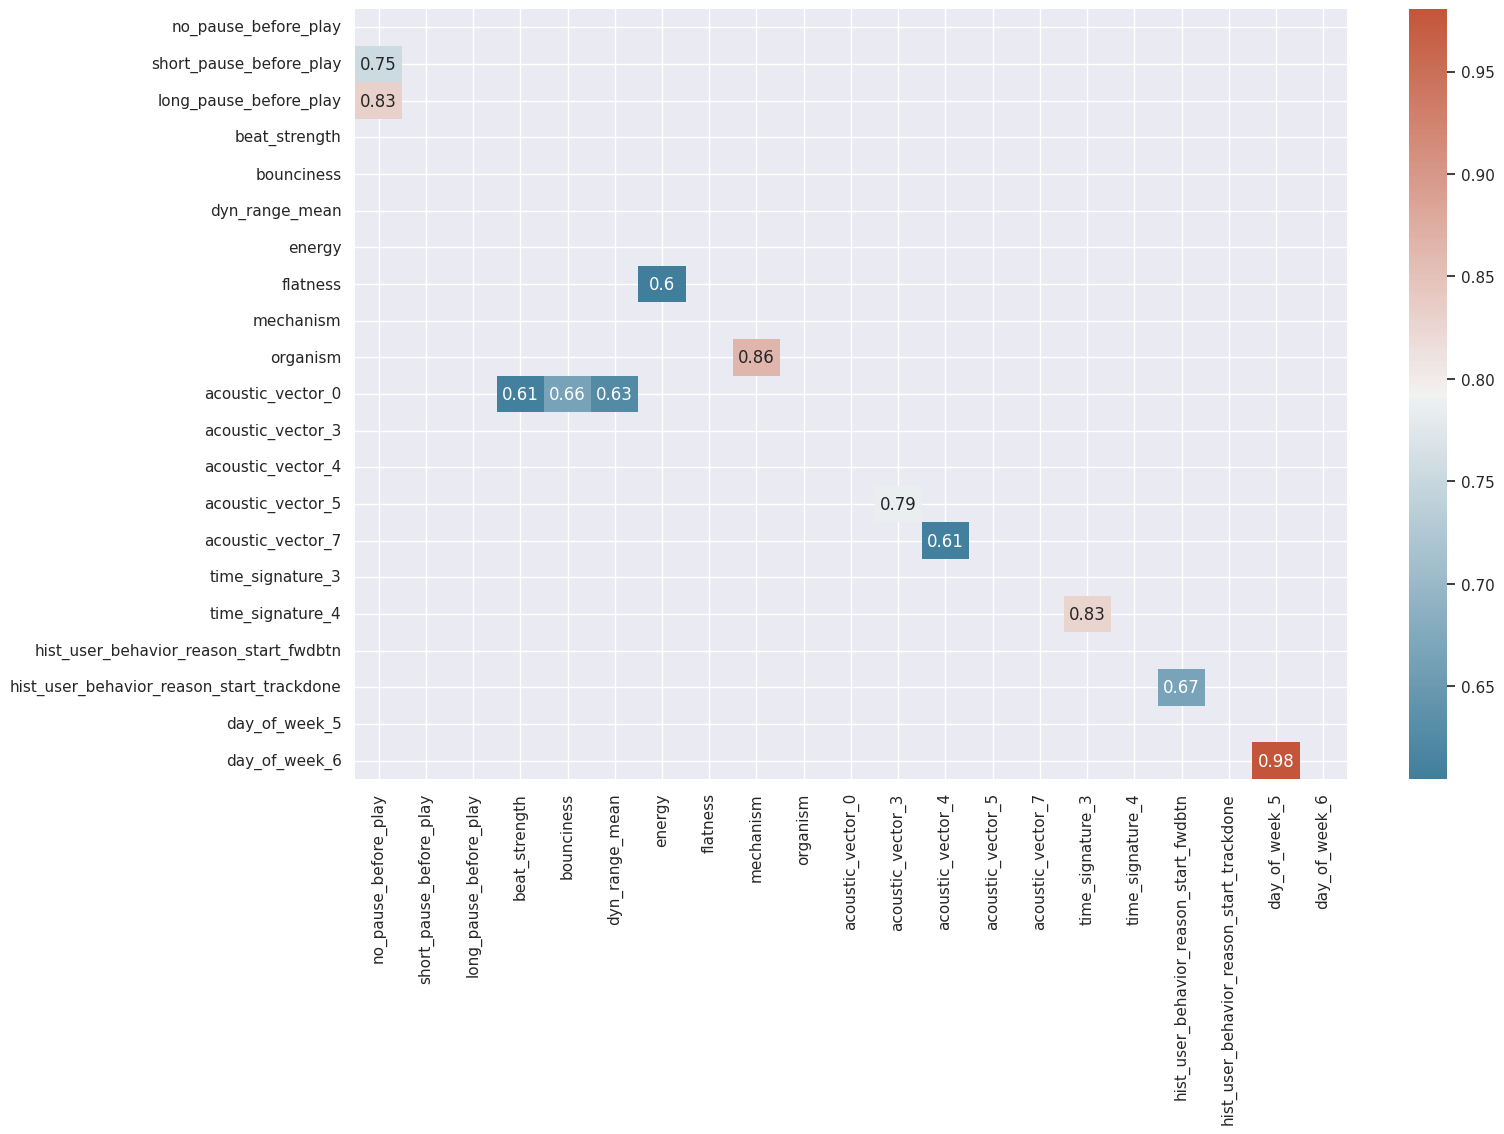

In [49]:
# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(16, 10))
# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap
sns.heatmap(corr,mask=mask, annot = True,cmap=cmap)

We generated a heatmap to visualize the correlation coefficient values, and from the plot, we can make the following conclusions:

- There is a high positive correlation between the acousticness-related features within the group. For instance, acoustic_vector_0 is strongly correlated with beat_strength, bounciness, and dyn_range_mean, while acoustic_vector_3 is highly correlated with acoustic_vector_5, and acoustic_vector_4 is strongly correlated with acoustic_vector_7. This correlation is reasonable since each music genre tends to have consistent acoustic characteristics.

- We also observed some highly correlated pairs in terms of user behavior. For example, we found a high correlation between no_pause_before_play and both short_pause_before_play and long_pause_before_play. This is reasonable because users either pause or do not pause before playing the track. Additionally, we found a high correlation between the skip behavior and hist_user_behavior_reason_end_trackdone, which is sensible because if the user's action led to the current track playback ending, it indicates that they had already listened to the track and did not skip it.

- The day_of_week distribution pattern is close to binary, with most users listening on either Saturday or Sunday. Thus, day_of_week_5 and day_of_week_6 are highly correlated with each other.




## 4 Principle Component Analysis (PCA)

Principal Component Analysis is a widely used statistical technique for data visualization, noise reduction, data compression, feature extraction, performance improvement, data interpretation, and covariate adjustment. For this project we utilize PCA to reduce dimensionality, visualizing complex data, filtering out noise, and enhancing machine learning algorithm performance.

In [50]:
df = df_normalized
y = df.skip
X = df.drop(columns =['skip'])

In [51]:
pca = PCA()
X_pca = pca.fit_transform(X)
variance=np.cumsum(pca.explained_variance_ratio_)

We can plot out cumulative proportion of variance to observe the sum of the explained variances of successive principal components as a proportion of the total variance in the original dataset. It is a measure of how much of the original data's variation is captured by a given number of principal components.

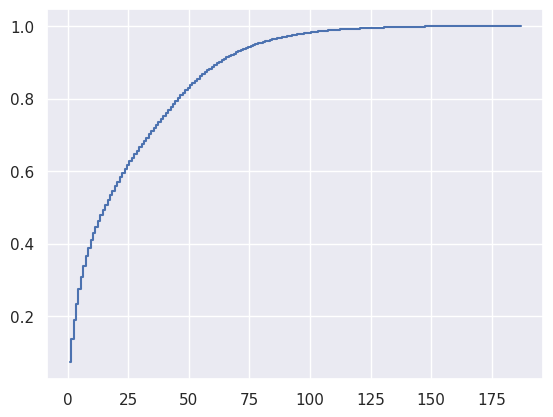

In [52]:
plt.step(range(1,len(variance)+1), variance, where='mid')

The cumulative proportion of variance helps to determine how many principal components should be retained for further analysis, as it indicates the percentage of the original information preserved when using a specific number of components. We chose 50 as the number of dimensions with approximately 82% information of the data.

In [53]:
pca = PCA(n_components=50)
pca.fit(X)
x_pca_transformed = pca.transform(X)

In [54]:
df.shape,x_pca_transformed.shape

((167880, 188), (167880, 50))

Train test split

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=2)

Train test split with PCA transformation

In [56]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(x_pca_transformed,y,test_size=0.2,random_state=2)
# X_train_pca, X_val_pca, y_val, y_val = train_test_split(X_train_pca,y_train,test_size=0.2,random_state=2)

## 5 Baseline model: Logistic regression

Logistic regression is a simple supervised machine learning algorithm used for binary classification. Considering its simplicity, interpretability, and effectiveness, we used it as our baseline model. Our baseline logistic regression model achieved an accuracy of 76.6% with 78.1% label 0 precision.

In [57]:
def plot_confusion_matrix(cf_matrix):
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



              precision    recall  f1-score   support

           0      0.781     0.718     0.748     16246
           1      0.754     0.811     0.781     17330

    accuracy                          0.766     33576
   macro avg      0.767     0.764     0.765     33576
weighted avg      0.767     0.766     0.765     33576



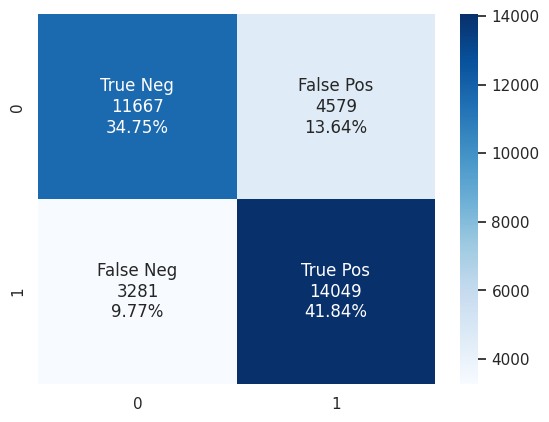

In [58]:
from sklearn.linear_model import LogisticRegression

logr_model = LogisticRegression().fit(X_train2, y_train2)
y_pred_logr = logr_model.predict(X_test2)
log_acc = logr_model.score(X_test2, y_test2)
plot_confusion_matrix(confusion_matrix(y_test2, y_pred_logr))
print(classification_report(y_test2, y_pred_logr, digits=3))

In [59]:
print("Accuracy: %.1f%%"% (log_acc*100))

Accuracy: 76.6%


## 6 k-nearest neighbors(KNN)
The k-nearest neighbors algorithm, also known as KNN or k-NN, is a non-parametric, supervised learning classifier, which uses proximity to make classifications or predictions about the grouping of an individual data point.

KNN works by computing the distances between the test sample and all the training samples, and then finding the k nearest neighbors of the test sample based on these distances. The output of KNN is determined by the majority vote of the k-nearest neighbors for classification, or by the average of the k-nearest neighbors for regression.

Accuracy: 73.3%
Classification Report : 


              precision    recall  f1-score   support

         0.0      0.743     0.684     0.712     16223
         1.0      0.725     0.779     0.751     17353

    accuracy                          0.733     33576
   macro avg      0.734     0.731     0.731     33576
weighted avg      0.734     0.733     0.732     33576



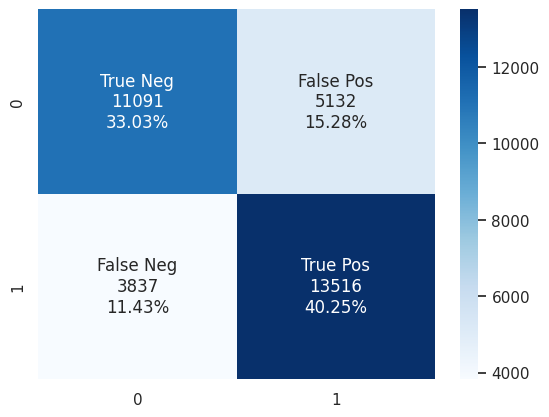

In [60]:
knn_model = KNeighborsClassifier().fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
acc_knn = knn_model.score(X_test, y_test)
print("Accuracy: %.1f%%"% (acc_knn*100))
print("Classification Report : \n\n")
print(classification_report(y_test, y_pred_knn, digits=3))
plot_confusion_matrix(confusion_matrix(y_test, y_pred_knn))

###6.1 KNN with PCA
During our running with KNN, we founfd that KNN with large dimensionality takes very long to train. This is also the main challenges with KNN is the curse of dimensionality. As the number of features in the dataset increases, the number of training samples required to maintain the same level of accuracy also increases exponentially. This is because the distance between the samples becomes more and more uniform in high-dimensional space, making it difficult to distinguish between different classes.

We applied PCA to address the curse of dimensionality by reducing the dimensionality of the input space while preserving as much of the original variance as possible. 

In [61]:
knn_model = KNeighborsClassifier().fit(X_train_pca, y_train_pca)
y_pred_knn_pca = knn_model.predict(X_test_pca)
acc_knn_pca = knn_model.score(X_test_pca, y_test_pca)
print("Accuracy: %.1f%%"% (acc_knn_pca*100))

Accuracy: 72.8%


Classification Report : 


              precision    recall  f1-score   support

         0.0      0.739     0.677     0.707     16223
         1.0      0.720     0.776     0.747     17353

    accuracy                          0.728     33576
   macro avg      0.729     0.727     0.727     33576
weighted avg      0.729     0.728     0.728     33576



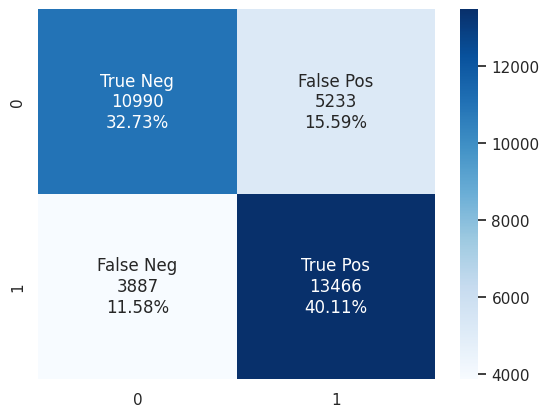

In [62]:
print("Classification Report : \n\n")
print(classification_report(y_test, y_pred_knn_pca, digits=3))
plot_confusion_matrix(confusion_matrix(y_test, y_pred_knn_pca))

###6.2 KNN with grid search and cross validation

To better tune the hyperparameters, we use grid search method to find the best model. This result in a best score of 75.4% and an accuracy of 76.1%. Using grid search had improved 3.3%. 

In [63]:
params = {'n_neighbors': range(20,40,2),
          'weights': ['uniform', 'distance']
         }

knn = KNeighborsClassifier()

model = GridSearchCV(knn, params, cv=3,verbose=10)
model.fit(X_train_pca, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3; 1/20] START n_neighbors=20, weights=uniform............................
[CV 1/3; 1/20] END n_neighbors=20, weights=uniform;, score=0.754 total time=  29.4s
[CV 2/3; 1/20] START n_neighbors=20, weights=uniform............................
[CV 2/3; 1/20] END n_neighbors=20, weights=uniform;, score=0.758 total time=  31.5s
[CV 3/3; 1/20] START n_neighbors=20, weights=uniform............................
[CV 3/3; 1/20] END n_neighbors=20, weights=uniform;, score=0.754 total time=  29.2s
[CV 1/3; 2/20] START n_neighbors=20, weights=distance...........................
[CV 1/3; 2/20] END n_neighbors=20, weights=distance;, score=0.754 total time=  28.8s
[CV 2/3; 2/20] START n_neighbors=20, weights=distance...........................
[CV 2/3; 2/20] END n_neighbors=20, weights=distance;, score=0.757 total time=  28.6s
[CV 3/3; 2/20] START n_neighbors=20, weights=distance...........................
[CV 3/3; 2/20] END n_neighbors=

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(20, 40, 2),
                         'weights': ['uniform', 'distance']},
             verbose=10)

In [64]:
# Print best hyperparameters and corresponding mean test score
print(f"Best hyperparameters: {model.best_params_}")
print(f"Corresponding mean test score: {model.best_score_:.3f}")

# Evaluate best model on test set
best_knn = model.best_estimator_
acc_knn = best_knn.score(X_test_pca, y_test)
print("Accuracy: %.1f%%"% (acc_knn*100))

Best hyperparameters: {'n_neighbors': 38, 'weights': 'uniform'}
Corresponding mean test score: 0.761
Accuracy: 76.2%


In [65]:
y_pred_knn_grid = best_knn.predict(X_test_pca)

Classification Report : 


              precision    recall  f1-score   support

         0.0      0.780     0.706     0.741     16223
         1.0      0.748     0.814     0.779     17353

    accuracy                          0.762     33576
   macro avg      0.764     0.760     0.760     33576
weighted avg      0.763     0.762     0.761     33576



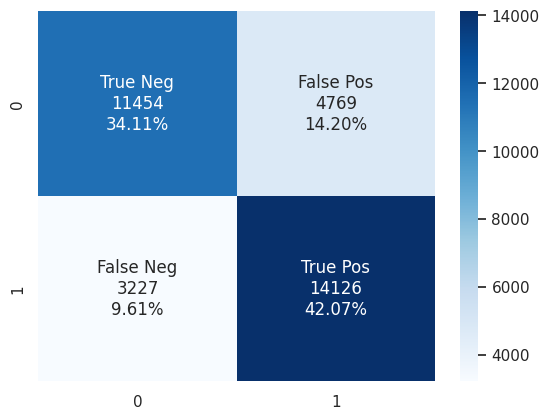

In [66]:
cm_knn = confusion_matrix(y_test_pca, y_pred_knn_grid)
print("Classification Report : \n\n")
print(classification_report(y_test, y_pred_knn_grid, digits=3))
plot_confusion_matrix(confusion_matrix(y_test, y_pred_knn_grid))

## 7 Decision Tree Classifier

A decision tree is a supervised learning algorithm that is used for both classification and regression analysis. A decision tree classifier is a specific type of decision tree that is used for classification tasks. The algorithm works by recursively splitting the training data into subsets based on the values of the input features, until each subset is homogeneous in terms of the output variable, or until a stopping criterion is met. 

### 7.1 Baseline Decision Tree

We first train a model with max_depth=10 as the baseline for Decision Tree model.

In [67]:
# Training step, on X_train with y_train
clf = DecisionTreeClassifier(random_state=42,max_depth=3)
clf = clf.fit(X_train,y_train)

# Prediction step, with X_test (and we will 
# validate accuracy against y_test)
dt_pre = clf.predict(X_test)

# Test accuracy, ie Jaccard distance of matched items
clf_acc = sklearn.metrics.accuracy_score(dt_pre,y_test)
print("Accuracy: %.1f%%"% (clf_acc*100))

Accuracy: 76.5%


### 7.2 Tune the tree depth using cross-validation

In [68]:
# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        print('Depth:',depth, 'accuracy:', accuracy_scores)
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()



Depth: 2 accuracy: []
Depth: 4 accuracy: [0.7629482368358351]
Depth: 6 accuracy: [0.7629482368358351, 0.7673189182749584]
Depth: 8 accuracy: [0.7629482368358351, 0.7673189182749584, 0.7716672623302359]
Depth: 10 accuracy: [0.7629482368358351, 0.7673189182749584, 0.7716672623302359, 0.7753305932809149]
Depth: 12 accuracy: [0.7629482368358351, 0.7673189182749584, 0.7716672623302359, 0.7753305932809149, 0.7828285084584227]
Depth: 14 accuracy: [0.7629482368358351, 0.7673189182749584, 0.7716672623302359, 0.7753305932809149, 0.7828285084584227, 0.7952853228496545]
Depth: 16 accuracy: [0.7629482368358351, 0.7673189182749584, 0.7716672623302359, 0.7753305932809149, 0.7828285084584227, 0.7952853228496545, 0.8115543840838695]
Depth: 18 accuracy: [0.7629482368358351, 0.7673189182749584, 0.7716672623302359, 0.7753305932809149, 0.7828285084584227, 0.7952853228496545, 0.8115543840838695, 0.8307868715749345]
Depth: 20 accuracy: [0.7629482368358351, 0.7673189182749584, 0.7716672623302359, 0.7753305932

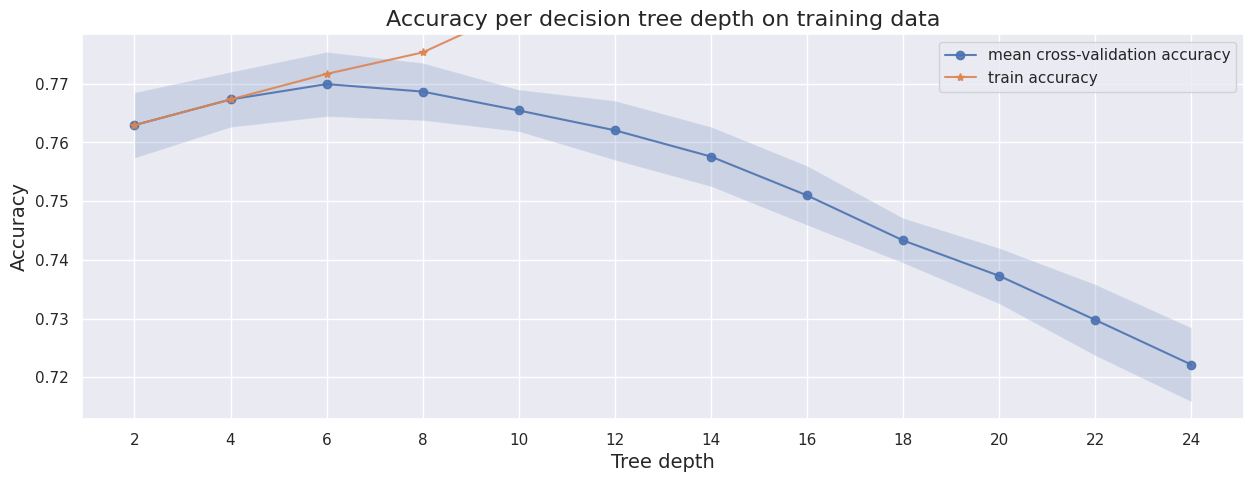

In [69]:
# fitting trees of depth 2 to 24
sm_tree_depths = range(2,26,2)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')


In [70]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

The depth-6 tree achieves the best mean cross-validation accuracy 76.99324 +/- 0.2756% on training dataset


In [71]:
# Training step, on X_train with y_train
clf = DecisionTreeClassifier(random_state=42,max_depth=sm_best_tree_depth)
clf = clf.fit(X_train,y_train)

# Prediction step with X_test and we will validate accuracy against y_test)
y_pred_dt = clf.predict(X_test)

# Test accuracy, ie Jaccard distance of matched items
clf_acc = sklearn.metrics.accuracy_score(y_pred_dt,y_test)
print("Accuracy: %.1f%%"% (clf_acc*100))


Accuracy: 76.8%


We achieved an unspectacular improvement in accuracy of 0.3%.

              precision    recall  f1-score   support

         0.0      0.781     0.724     0.751     16223
         1.0      0.759     0.810     0.783     17353

    accuracy                          0.768     33576
   macro avg      0.770     0.767     0.767     33576
weighted avg      0.769     0.768     0.768     33576



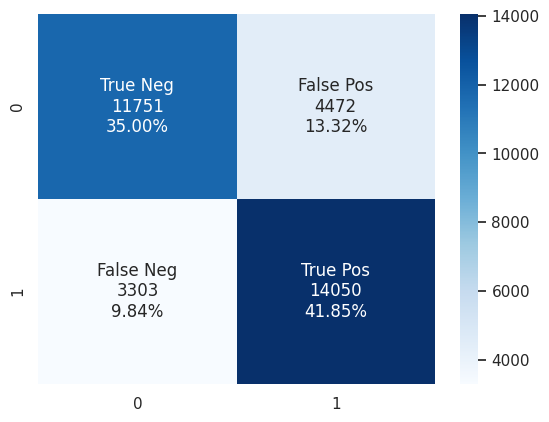

In [72]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt, digits=3))

We then visualize the result to see how Decision tree model split the nodes.

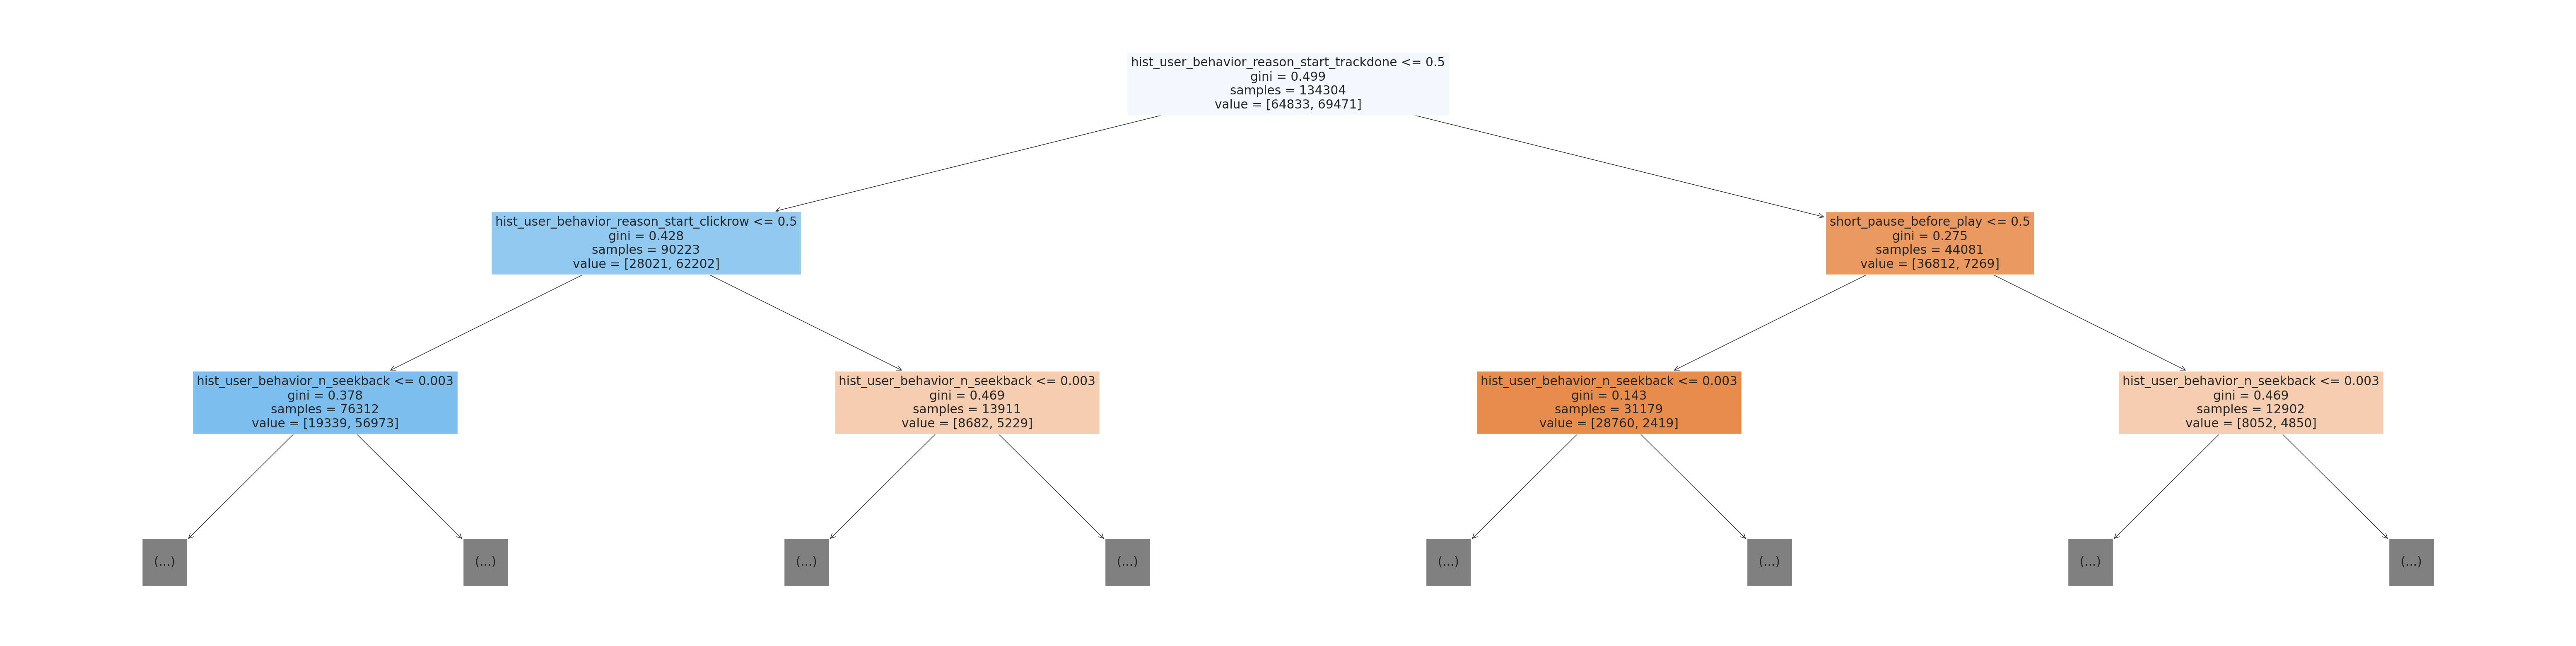

In [73]:
from sklearn.tree import plot_tree, export_text
plt.figure(figsize =(80,20))
plot_tree(clf, feature_names=X_test.columns, max_depth=2, filled=True);

## 8 Random Forest

We adopted random forest to combine multiple decision trees and overcome the overfitting problems that can occur with individual decision trees. By using multiple trees, the algorithm can capture more complex relationships between the input features and the output variable, and can also provide estimates of feature importance.

Compared to decision trees we used earlier, random forests are less interpretable but more robust and less prone to overfitting. They also tend to perform better than individual decision trees on larger datasets. Additionally, random forests can provide estimates of feature importance, which can be useful for feature selection and interpretation.

As Random forest models can take a lot of time to train, we decided to use tfdf.keras.RandomForestModel to train. It can scale efficiently to large and complex datasets. It supports distributed training on multiple GPUs or CPUs, and can handle datasets with millions or even billions of examples.

### 8.1 TensorFlow model

In [74]:
X_train_df, X_test_df = train_test_split(df, test_size=0.2, 
                                   random_state=42, 
                                   shuffle=True)
target = "skip"

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_train_df, label=target, task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_test_df, label=target, task=tfdf.keras.Task.REGRESSION)


In [75]:
# instantiate the model
model_rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)

# optional step - add evaluation metrics
model_rf.compile(metrics=["mse", "mape",'accuracy'])

# fit the model
model_rf.fit(x=train_ds)

Use /tmp/tmp3j0i3735 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:27.331256. Found 134304 examples.
Training model...
Model trained in 0:22:54.641485
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


With random tree model, we get an accuracy of 77.7%, whcih is the highest across all models.

In [76]:
evaluation = model_rf.evaluate(test_ds, return_dict=True)
for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

34/34 [==============================] - 7s 167ms/step - loss: 0.0000e+00 - mse: 0.1581 - mape: 159357152.0000 - accuracy: 0.7770
loss: 0.0000
mse: 0.1581
mape: 159357152.0000
accuracy: 0.7770


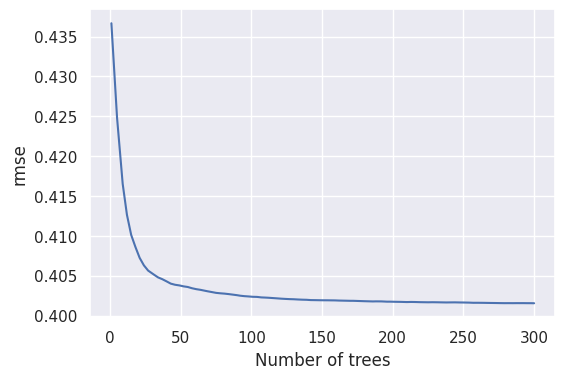

In [77]:
logs = model_rf.make_inspector().training_logs()

plt.figure(figsize=(6, 4))
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("rmse")

plt.show()

In [78]:
# Prediction step with X_test and we will validate accuracy against y_test
y_pred_rf = model_rf.predict(test_ds)
y_pred_rf = (y_pred_rf > 0.5).astype(int)
y_true = X_test_df['skip']

34/34 [==============================] - 8s 214ms/step


Accuracy: 77.7%
              precision    recall  f1-score   support

         0.0      0.797     0.723     0.758     16246
         1.0      0.761     0.828     0.793     17330

    accuracy                          0.777     33576
   macro avg      0.779     0.775     0.776     33576
weighted avg      0.779     0.777     0.776     33576



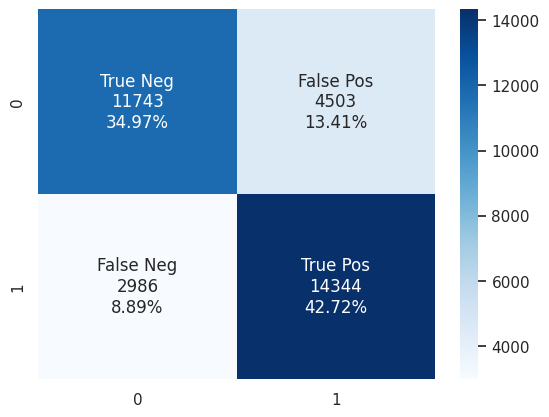

In [79]:
# Test accuracy, ie Jaccard distance of matched items
rf_acc = sklearn.metrics.accuracy_score(y_pred_rf,y_true)
print("Accuracy: %.1f%%"% (rf_acc*100))

# plot confusion matrix
plot_confusion_matrix(confusion_matrix(y_true, y_pred_rf))

#print classification report
print(classification_report(y_true, y_pred_rf, digits=3))

### 8.2 Feature importance analysis and visualization

To further intrepret the results, we print out the variable importances to understand which features or variables were most important in predicting the skipping behavior. By printing out the summary, we found that there are four types of variable importance measures

*   **INV_MEAN_MIN_DEPTH**: This measures the mean of the minimum depth at which a variable appears in the trees of the random forest. This importance measure tends to favor features that can separate the data into smaller subgroups early on in the decision tree.

*   **NUM_AS_ROOT**: This measures the number of times a variable is used as the root node of a tree. This importance measure tends to favor features that are strong predictors of the target variable.

*   **NUM_NODES**: This measures the total number of times a variable is used as a split in the decision trees. Features that are used frequently as splits tend to have higher NUM_NODES scores. This importance measure tends to favor features that are relevant for predicting the target variable.

*   **SUM_SCORE**: This measures the sum of the Gini index reduction scores (or other impurity-based scores) across all the trees in the random forest for each feature. Features that contribute more to reducing the impurity tend to have higher SUM_SCORE values. 

In [80]:
model_rf.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (187):
	acoustic_vector_0
	acoustic_vector_1
	acoustic_vector_2
	acoustic_vector_3
	acoustic_vector_4
	acoustic_vector_5
	acoustic_vector_6
	acoustic_vector_7
	acousticness
	beat_strength
	bounciness
	context_switch
	context_type_catalog
	context_type_charts
	context_type_editorial_playlist
	context_type_personalized_playlist
	context_type_radio
	context_type_user_collection
	danceability
	day_of_week_0
	day_of_week_1
	day_of_week_2
	day_of_week_3
	day_of_week_4
	day_of_week_5
	day_of_week_6
	duration
	dyn_range_mean
	energy
	flatness
	hist_user_behavior_is_shuffle
	hist_user_behavior_n_seekback
	hist_user_behavior_n_seekfwd
	hist_us

In [81]:
def plot_importance(variable_importance_metric):
  inspector = model_rf.make_inspector()

  plt.figure(figsize=(9, 3))

  # Mean decrease in AUC of the class 1 vs the others.
  variable_importances = inspector.variable_importances()[variable_importance_metric][:10]

  # Extract the feature name and importance values.
  #
  # `variable_importances` is a list of <feature, importance> tuples.
  feature_names = [vi[0].name for vi in variable_importances]
  feature_importances = [vi[1] for vi in variable_importances]
  # The feature are ordered in decreasing importance value.
  feature_ranks = range(len(feature_names))

  bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
  plt.yticks(feature_ranks, feature_names)
  plt.gca().invert_yaxis()

  # Label each bar with values
  for importance, patch in zip(feature_importances, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

  plt.xlabel(variable_importance_metric)
  plt.tight_layout()
  plt.show()

We first use INV_MEAN_MIN_DEPTH and NUM_AS_ROOT measures to identify a few key features that can have a large impact on the recommendation systems and user experience. 



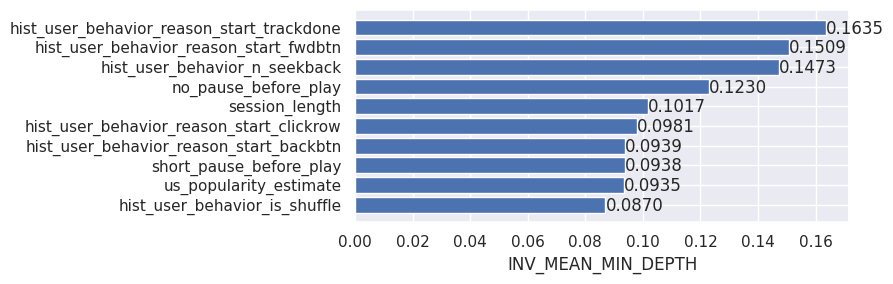

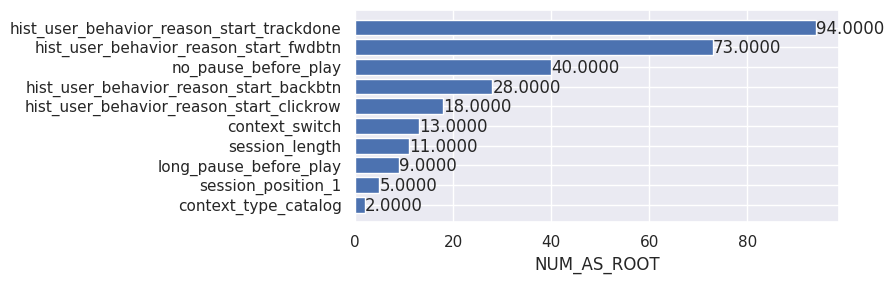

In [82]:
for i in ["INV_MEAN_MIN_DEPTH",'NUM_AS_ROOT']:
  plot_importance(i)



From the results, we can include the context influence the sequential skip behavior the most:
* the "hist_user_behavior_reason_start_trackdone" feature has the highest importance score, indicating that it is a strong predictor of sequential skip behavior. This feature refers to the reason why a user started playing a song (in this case, because the previous song ended naturally). This suggests that the context of how a user started playing a song can be an important factor in predicting whether they will skip it.

* Features such as "hist_user_behavior_reason_start_fwdbtn," "hist_user_behavior_reason_start_backbtn," and "hist_user_behavior_reason_start_clickrow" all have high importance scores. These features relate to the specific actions taken by the user to start playing a song (e.g., clicking on the forward or back button), and suggest that user behavior immediately prior to playing a song is an important factor in predicting whether they will skip it.

* Other features that have relatively high importance scores include "no_pause_before_play," "long_pause_before_play," and "context_switch," which all relate to the context in which a user starts playing a song. The importance of these features suggests that the interruption or continuity of the user's listening experience may influence their likelihood of skipping a song.

We then use the NUM_NODES and SUM_SCORE measures to identify a larger set of features that collectively contribute to the recommendation systems and user experience.

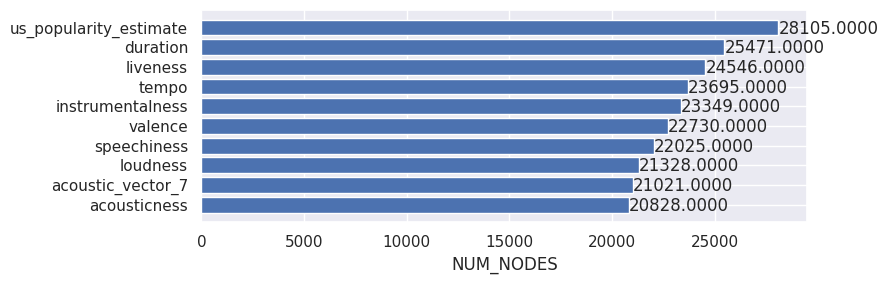

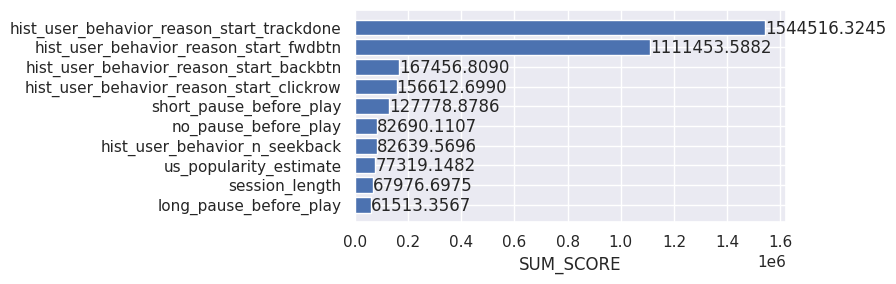

In [83]:
for i in ['NUM_NODES','SUM_SCORE']:
  plot_importance(i)



Looking at the results, we can see that the "us_popularity_estimate" feature was the most important, followed by "duration," "liveness," "tempo," and "instrumentalness." Other features that had high importance values include "valence," "speechiness," and "loudness."

From a user behavior perspective, the high importance of "us_popularity_estimate" could indicate that users are more likely to skip songs that are less popular. Similarly, the importance of "duration" could suggest that users may be more likely to skip longer songs.

The importance of features like "valence" and "energy" could suggest that users are more likely to skip songs with certain emotional tones or energy levels that do not match their preferences. Meanwhile, the importance of features like "acousticness" and "instrumentalness" could indicate that users may be more likely to skip songs with certain sound characteristics that they do not enjoy.

In [84]:
tfdf.model_plotter.plot_model_in_colab(model_rf, tree_idx=0, max_depth=4)

##9 XGBoost
XGBoost, short for Extreme Gradient Boosting, is a machine learning algorithm designed for supervised learning tasks. It provides an efficient implementation of gradient boosted decision trees, and could yield accurate results.

The key idea behind Gradient Boosting is to iteratively combine weak learners, typically decision trees, to create a strong learner by optimizing a loss function. XGBoost improves upon the standard Gradient Boosting algorithm by introducing several optimization techniques including regularization, early stopping, parallel learning, etc. 

###9.1 Baseline XGBoost
We chose XGBoost with default hyperparameter values as our baseline XGBoost model. Our baseline XGBoost achieved an accuracy of 76.5% with 77.4% label 0 precision.

              precision    recall  f1-score   support

           0      0.774     0.726     0.749     16246
           1      0.757     0.801     0.778     17330

    accuracy                          0.765     33576
   macro avg      0.765     0.763     0.764     33576
weighted avg      0.765     0.765     0.764     33576

Accuracy: 76.5%


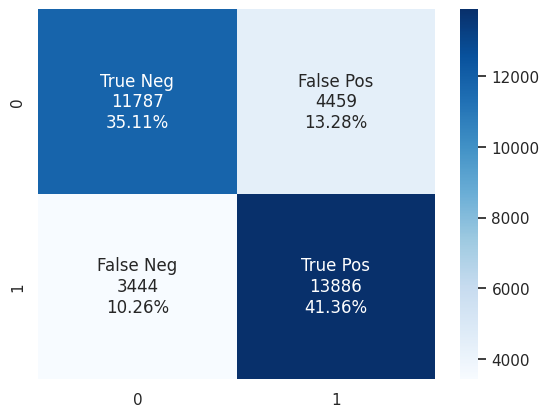

In [85]:
xgb_model = xgb.XGBClassifier(random_state=42, tree_method='gpu_hist').fit(X_train2, y_train2)
y_pred_xgb = xgb_model.predict(X_test2)
xgb_acc = xgb_model.score(X_test2, y_test2)

# Confusion matrix and summary performance
plot_confusion_matrix(confusion_matrix(y_test2, y_pred_xgb))
print(classification_report(y_test2, y_pred_xgb, digits=3))
xgb_acc = sklearn.metrics.accuracy_score(y_pred_xgb,y_test2)
print("Accuracy: %.1f%%"% (xgb_acc*100))

###9.2 Tuned XGBoost

We tuned our XGBoost model using Bayesian optimization, Random Search, and Threshold-moving.

####9.2.1 Bayesian optimization with k-fold cross validation

We used Bayesian optimization with k-fold cross validation to tune 'learning_rate', 'max_depth', 'subsample', 'colsample_bytree',and 'n_estimators'. The optimal parameter values are: 

*   learning_rate = 0.1

*   max_depth = 4

*   subsample = 1

*   colsample_bytree = 1

*   n_estimators = 283

In [86]:
# Tune XGBoost: Bayesian optimization with k-fold cross validation
xgb_model = xgb.XGBClassifier(booster='gbtree',
                objective='binary:logistic', 
                eval_metric='logloss', 
                gamma=0,
                random_state=42,
                tree_method='gpu_hist')

search_spaces = {
    'learning_rate': (0.1, 0.4),
    'max_depth': (1, 4),
    'subsample': (0, 1),
    'colsample_bytree': (0, 1),
    'n_estimators': (80, 500),
}

opt = BayesSearchCV(
    xgb_model,
    search_spaces,
    n_iter=30,
    cv=5,
    n_jobs=-1,
    random_state=42
)

opt.fit(X_train2, y_train2)
print(opt.best_params_)

/usr/local/lib/python3.9/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



OrderedDict([('colsample_bytree', 1), ('learning_rate', 0.1), ('max_depth', 4), ('n_estimators', 283), ('subsample', 1)])


We then built an optimized XGBoost model using the optimal parameter values. The optimized XGBoost model achieved an accuracy of 77.3% with 78.6% label 0 precision.

In [87]:
# Train model using optimal hyperparameters obtained above
watchlist = [(dtrain, 'train'), (dtest, 'test')]
tuned_xgb = xgb.train(opt.best_params_, dtrain, num_boost_round=opt.best_params_['n_estimators'], evals=watchlist)

[22:45:02] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	train-rmse:0.48382	test-rmse:0.48367
[1]	train-rmse:0.47030	test-rmse:0.47001
[2]	train-rmse:0.45905	test-rmse:0.45856
[3]	train-rmse:0.44971	test-rmse:0.44905
[4]	train-rmse:0.44199	test-rmse:0.44122
[5]	train-rmse:0.43561	test-rmse:0.43471
[6]	train-rmse:0.43024	test-rmse:0.42924
[7]	train-rmse:0.42591	test-rmse:0.42479
[8]	train-rmse:0.42235	test-rmse:0.42116
[9]	train-rmse:0.41917	test-rmse:0.41786
[10]	train-rmse:0.41674	test-rmse:0.41536
[11]	train-rmse:0.41451	test-rmse:0.41303
[12]	train-rmse:0.41279	test-rmse:0.41124
[13]	train-rmse:0.41132	test-rmse:0.40974
[14]	train-rmse:0.41019	test-rmse:0.40858
[15]	train-rmse:0.40912	test-rmse:0.40746
[16]	train-rmse:0.40834	test-rmse:0.40666
[17]	train-rmse:0.40757	test-rmse:0.40585
[18]	train-rmse:0.40704	test-rmse:0.40531
[19]	train-rmse:0.40648	test-rmse:0.40474
[20]	train-rmse:0.40596	test-rmse:0.40423
[21]	train-rmse:0.40561	test-rmse:0.40

              precision    recall  f1-score   support

           0      0.786     0.731     0.757     16246
           1      0.763     0.814     0.788     17330

    accuracy                          0.773     33576
   macro avg      0.775     0.772     0.772     33576
weighted avg      0.774     0.773     0.773     33576

Accuracy: 77.3%


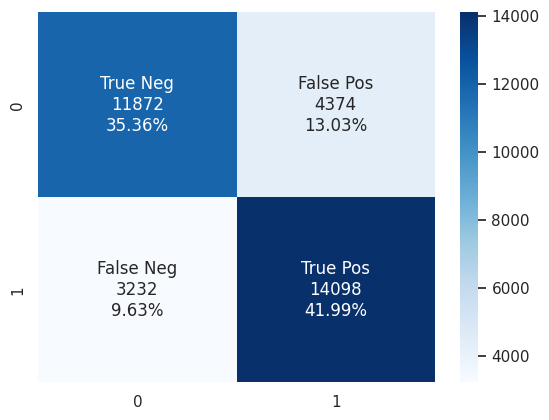

In [88]:
# Predict on test set using default threshold of 0.5
tuned_y_pred = tuned_xgb.predict(dtest) > 0.5
tuned_y_pred_proba = tuned_xgb.predict(dtest)

# Confusion matrix and summary performance
plot_confusion_matrix(confusion_matrix(y_test2, tuned_y_pred))
print(classification_report(y_test2, tuned_y_pred, digits=3))
tuned_xgb_acc = sklearn.metrics.accuracy_score(tuned_y_pred,y_test2)
print("Accuracy: %.1f%%"% (tuned_xgb_acc*100))

####9.2.2 Regularization using Random Search
To regularize the optimized XGBoost model obtained above, we used Random Search to find the best "gamma". The regularized XGBoost model achieved an accuracy of 77.3% with 78.4% label 0 precision.

In [89]:
# Regularize XGBoost
tuned_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    booster='gbtree',
    learning_rate=opt.best_params_['learning_rate'],
    max_depth=opt.best_params_['max_depth'],
    subsample=opt.best_params_['subsample'],
    colsample_bytree=opt.best_params_['colsample_bytree'],
    n_estimators=opt.best_params_['n_estimators'], 
    random_state=42,
    tree_method='gpu_hist'
)

cv_params = {
    'gamma': np.arange(0, 50)
}

n_folds = 5
cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    tuned_xgb_model,
    param_distributions=cv_params,
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train2, y_train2)
best_gamma = random_search.best_params_['gamma']
print('Best gamma:', best_gamma)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best gamma: 1


              precision    recall  f1-score   support

           0      0.784     0.733     0.757     16246
           1      0.764     0.810     0.786     17330

    accuracy                          0.773     33576
   macro avg      0.774     0.772     0.772     33576
weighted avg      0.773     0.773     0.772     33576

Accuracy: 77.3%


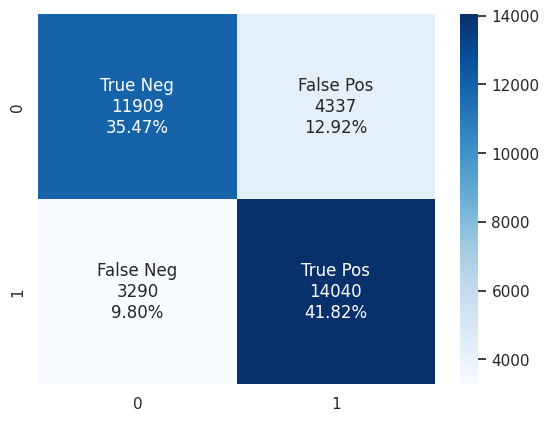

In [90]:
final_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    booster='gbtree',
    gamma=best_gamma,
    learning_rate=opt.best_params_['learning_rate'],
    max_depth=opt.best_params_['max_depth'],
    subsample=opt.best_params_['subsample'],
    colsample_bytree=opt.best_params_['colsample_bytree'],
    n_estimators=opt.best_params_['n_estimators'], 
    random_state=42,
    tree_method='gpu_hist'
)

final_xgb.fit(X_train2, y_train2)

regularized_y_pred = final_xgb.predict(X_test2) > 0.5
regularized_y_proba = final_xgb.predict_proba(X_test2)[:, 1]

# Confusion matrix and summary performance
plot_confusion_matrix(confusion_matrix(y_test2, regularized_y_pred))
print(classification_report(y_test2, regularized_y_pred, digits=3))
regularized_xgb_acc = sklearn.metrics.accuracy_score(regularized_y_pred,y_test2)
print("Accuracy: %.1f%%"% (regularized_xgb_acc*100))

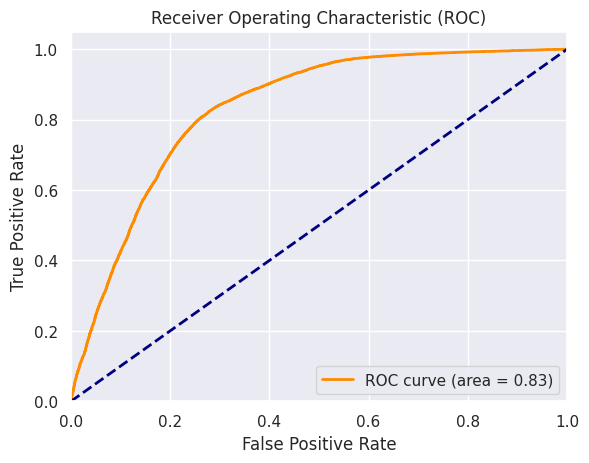

In [91]:
fpr, tpr, _ = roc_curve(y_test2, regularized_y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

####9.2.3 Threshold-moving

The threshold determines how confident the model needs to be in its predictions before assigning a positive class label. To determine the best threshold for classification label prediction, we utilized the threshold-moving method to find the threshold resulting in lowest expected_cost (formula: num(false positive) + 2*num(false negative)).

As the threshold increases, the model becomes more conservative and only predicts skipping it is more confident about. This results in a higher precision rate. On the other hand, when the threshold is lowered, the model becomes more liberal in making prediction of skipping, which may increase the recall rate. 

Considering the trade-off between the threshold and the precision rate, if the goal is to provide users with a small, highly accurate set of recommendations, it might be preferable to prioritize a higher precision rate at the expense of recall. Conversely, if the goal is to ensure users are exposed to as many relevant songs as possible, even if some incorrect recommendations are included, then a higher recall rate might be prioritized over precision.

Finally, we used the best threshold and constructed the final XGBoost model. Compared with the baseline XGBoost, our final XGBoost model significantly boosted label 0 precision by 10.8%, and maintained a relative high accuracy of 74.6%.

In [92]:
# Threshold-moving
expected_cost_list = []
threshold_list = np.arange(0, 1.0, 0.0005)

for threshold in threshold_list:
    test_preds_class = (regularized_y_proba > threshold).astype(int)
    cm = confusion_matrix(y_test2, test_preds_class)
    fp = cm[0][1]
    fn = cm[1][0]
    expected_cost = fp * 1 + fn * 2
    expected_cost_list.append(expected_cost)

min_cost_threshold = threshold_list[np.argmin(expected_cost_list)]
print('Optimal threshold:', min_cost_threshold)

Optimal threshold: 0.317


              precision    recall  f1-score   support

           0      0.882     0.548     0.676     16246
           1      0.687     0.931     0.791     17330

    accuracy                          0.746     33576
   macro avg      0.785     0.740     0.734     33576
weighted avg      0.781     0.746     0.735     33576

Accuracy: 74.6%


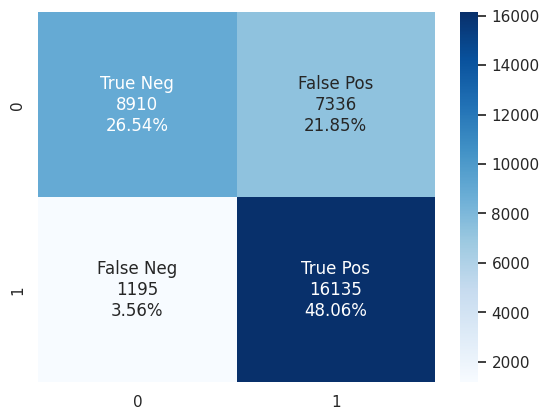

In [93]:
# Confusion Matrix at optimal threshold
final_y_pred = (regularized_y_proba > min_cost_threshold).astype(int)
plot_confusion_matrix(confusion_matrix(y_test2, final_y_pred))
print(classification_report(y_test2, final_y_pred, digits=3))
final_xgb_acc = sklearn.metrics.accuracy_score(final_y_pred,y_test2)
print("Accuracy: %.1f%%"% (final_xgb_acc*100))

## 10 Deep Learning

Deep learning is a machine learning technique that uses artificial neural networks to learn and make predictions from complex data. In this project, a neural network model was used alongside other machine learning models to predict users' behavior of skipping songs. The neural network model consists of multiple layers of interconnected nodes that can learn from data through a process of training. In this project, the neural network was trained on the sequential song skip dataset to identify patterns and relationships between features that are important in predicting song skips.

###Neural Network
we normalize the data, which means putting it on some common scale (value – mean / standard deviation).

In [94]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train2)
X_train2 = scaler.transform(X_train2)
X_test2 = scaler.transform(X_test2)

We use binary_crossentropy for the loss function and Stochastic Gradient Descent for the optimizer as well as different activation functions.

In [95]:
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(62,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])
model.fit(X_train2, y_train2, epochs=8, batch_size=128, verbose=1)

Epoch 1/8
1050/1050 [==============================] - 10s 5ms/step - loss: 0.6796 - accuracy: 0.5737
Epoch 2/8
1050/1050 [==============================] - 6s 5ms/step - loss: 0.5988 - accuracy: 0.7105
Epoch 3/8
1050/1050 [==============================] - 4s 4ms/step - loss: 0.5422 - accuracy: 0.7547
Epoch 4/8
1050/1050 [==============================] - 4s 4ms/step - loss: 0.5272 - accuracy: 0.7595
Epoch 5/8
1050/1050 [==============================] - 5s 4ms/step - loss: 0.5208 - accuracy: 0.7606
Epoch 6/8
1050/1050 [==============================] - 4s 4ms/step - loss: 0.5170 - accuracy: 0.7617
Epoch 7/8
1050/1050 [==============================] - 4s 4ms/step - loss: 0.5144 - accuracy: 0.7626
Epoch 8/8
1050/1050 [==============================] - 5s 5ms/step - loss: 0.5125 - accuracy: 0.7632


We use the evaluate() method to show the accuracy of the model, meaning the ratio (number of correct predictions)/(number of predictions).

In [96]:
y_pred2 = model.predict(X_test2)
score = model.evaluate(X_test2, y_test2, verbose=1)
print(score)

1050/1050 [==============================] - 3s 3ms/step - loss: 0.5109 - accuracy: 0.7641
[0.5109137892723083, 0.764087438583374]


              precision    recall  f1-score   support

           0      0.783     0.709     0.744     16246
           1      0.749     0.816     0.781     17330

    accuracy                          0.764     33576
   macro avg      0.766     0.762     0.763     33576
weighted avg      0.766     0.764     0.763     33576



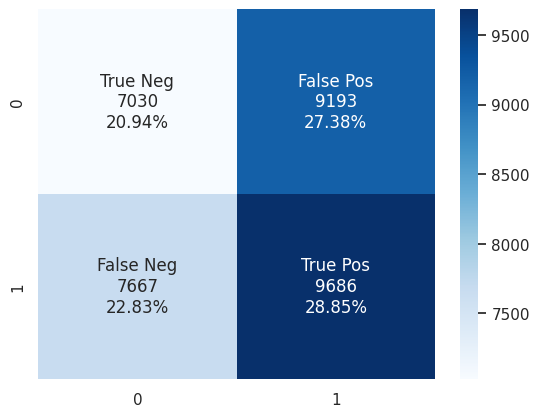

In [97]:
y_pred2 = (y_pred2 > 0.5).astype(int)
plot_confusion_matrix(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test2, y_pred2, digits=3))

## 11 Conclusion
For this project, we performed exploratory data analysis and utilized six different machine learning models to predict users' behavior of skipping songs. Our findings indicated that the Random Forest model performed the best, achieving an accuracy rate of 77.7% and a precision rate of 79.7% in predicting sequential song skips. Additionally, the regularized XGBoost model, using an optimal threshold of 0.317, attains the highest precision rate of 88.2%. This comes at the expense of predicting fewer not-skipped tracks, demonstrating that we can adjust the threshold according to various business objectives. We further dived into the importance of various features to better understand user behavior and provide product strategies aimed at improving the recommendation systems and user experience for music streaming services. 

###11.1 Machine Learning Model Summary
We employed logistic regression, k-nearest-neighbors, decision trees, random forest, XGBoost, and neural network models.


In terms of evaluation, we decided to use the total accuracy and precision of label 0 (not_skipped) for our evaluation metrics. We made this choice because we believe that, from a user perspective, having accurate song recommendations is extremely important. This is why we focused on overall accuracy and precision for the "not-skipped" (which corresponds to a 0 prediction label) classification. By using these two evaluation methods, we were able to assess the performance of each model's predictions. 

Below is a summary of the prediction accuracy for the six models we tested.


Model Name  | Best Accuracy  | Label 0 Precision 
-------------------|------------------ |------------------ 
Logistic Regression (Baseline)  | 76.6%  | 78.1%
KNN  | 76.2%  | 77.9%
Decision Tree  | 76.8%  | 78.1%
Random Forest  | **77.7%**  | 79.7%
XGBoost with threshold = 0.5 | 77.3%  | 78.4%
XGBoost with optimal threshold  | 74.6%  | **88.2%**
Neural Network  | 76.4%  | 78.0%

From the summary table, we can observe that: 


1. The Random Forest model achieved the highest accuracy rate of 77.7%, followed closely by the XGBoost model with 77.3%. Additionally, the XGBoost model with an optimal threshold of 0.317 had the highest precision rate for label 0 (not_skipped) with 88.2%, indicating that it performed better at identifying songs that users were unlikely to skip.


2. The XGBoost with optimal threshold and K-Nearest Neighbors models had the lowest accuracy rates of 74.6% and 76.2% respectively. 


3. However, it is noteworthy that all models showed relatively high precision rates for label 0, ranging from 77.9% to 88.2%. This suggests that the features used in the dataset were informative and relevant to predicting user behavior, with relatively low noise, which made it easier for all models to identify patterns accurately.

### 11.2 Feature Analysis

Based on the analysis of the variable importances, several factors appear to influence sequential skip behavior in the dataset. These factors include:


* **Song characteristics**: Features such as "us_popularity_estimate," "duration," "tempo," "valence," "energy," and "loudness" had high importance scores in the "NUM_NODES" measure, indicating that they are important predictors of sequential skip behavior. These features relate to the characteristics of the song itself, such as its popularity, duration, tempo, and emotional tone.


* **User behavior**: Features such as "hist_user_behavior_reason_start_trackdone," "hist_user_behavior_reason_start_fwdbtn," and "hist_user_behavior_reason_start_backbtn" had high importance scores in the "NUM_AS_ROOT" measure, indicating that they are strong predictors of sequential skip behavior. These features relate to the specific actions taken by the user to start playing a song, and suggest that user behavior immediately prior to playing a song is an important factor in predicting whether they will skip it.


* **The context in which a user starts playing a song**: Features such as "no_pause_before_play," "long_pause_before_play," and "context_switch" had relatively high importance scores in the "NUM_AS_ROOT" measure, suggesting that the interruption or continuity of the user's listening experience may influence their likelihood of skipping a song.


###11.3 Product Strategy Recommendation

Based on these findings, we can recommend the following strategies for improving the recommendation systems and user experience in music streaming platforms like Spotify:


* Take into account both the characteristics of the song and the user behavior and context when making recommendations to reduce sequential skip behavior.


* Consider the user's listening history and preferences, such as the types of songs and artists they have listened to in the past, in addition to the song characteristics and user behavior.


* Monitor and improve the user's listening experience, such as minimizing the length of pauses before playing a song, and minimizing context switches that may disrupt the user's experience.


In conclusion, music streaming platforms can provide a more personalized and seamless user experience, reducing the likelihood of sequential skip behavior and improving user satisfaction.


## 12 Future work
The achieved accuracy of 77.7% using a sample dataset is promising, considering the time and hardware constraints. However, utilizing the entire dataset provided by Spotify could result in even higher accuracy rates.


In the future, we may do more on three aspects to enhance performance:

* In terms of data, evaluating the performance of the models on a larger and more diverse dataset to increase their generalizability and effectiveness. 

* In terms of features, exploring the use of additional features such as lyrics, album art, and user-generated content to enhance the prediction of sequential skip behavior. 

* In terms of models, we can use LSTM, Bi-LSTM models as they are very good with long term memory. Also, we can use Encoder-Decoder architecture to preserve the sequence of the data. Also, transformers could be used which is a very complicated model but is very good for these kinds of sequential predictions.



